## Import Basic Libraries

In [1]:
# Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
sb.set() # set the default Seaborn style for graphics

# Import essential models and functions from sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.tree import plot_tree
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV

CONSTANT_SEED = 100

## Set Up Imported Data Set

In [2]:
main_heart_df = pd.read_csv('heart.csv')
main_heart_df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


In [3]:
# delete a single row by index value 449 - As shown in EDA
main_heart_df = main_heart_df.drop(labels=449, axis=0).reset_index(drop=True)

### Data preperation / One-Hot Encoding

In [4]:
IPzero_heart_df = main_heart_df.copy()

# Import the encoder from sklearn
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()

# OneHotEncoding of categorical predictors (not the response)
IPzero_heart_df_cat = IPzero_heart_df[['Sex','ChestPainType','FastingBS','RestingECG','ExerciseAngina','ST_Slope']]
ohe.fit(IPzero_heart_df_cat)
IPzero_heart_df_cat_ohe = pd.DataFrame(ohe.transform(IPzero_heart_df_cat).toarray(), 
                                  columns=ohe.get_feature_names_out(IPzero_heart_df_cat.columns))

# Check the encoded variables
IPzero_heart_df_cat_ohe.info()
print('')

# Combining Numeric features with the OHE Categorical features
IPzero_heart_df_num = IPzero_heart_df[['Age','RestingBP','Cholesterol','MaxHR','Oldpeak']]
IPzero_heart_df_res = IPzero_heart_df['HeartDisease']
IPzero_heart_df_ohe = pd.concat([IPzero_heart_df_num, IPzero_heart_df_cat_ohe, IPzero_heart_df_res], 
                           sort = False, axis = 1).reindex(index=IPzero_heart_df_num.index)

# Check the final dataframe
IPzero_heart_df_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 917 entries, 0 to 916
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Sex_F              917 non-null    float64
 1   Sex_M              917 non-null    float64
 2   ChestPainType_ASY  917 non-null    float64
 3   ChestPainType_ATA  917 non-null    float64
 4   ChestPainType_NAP  917 non-null    float64
 5   ChestPainType_TA   917 non-null    float64
 6   FastingBS_0        917 non-null    float64
 7   FastingBS_1        917 non-null    float64
 8   RestingECG_LVH     917 non-null    float64
 9   RestingECG_Normal  917 non-null    float64
 10  RestingECG_ST      917 non-null    float64
 11  ExerciseAngina_N   917 non-null    float64
 12  ExerciseAngina_Y   917 non-null    float64
 13  ST_Slope_Down      917 non-null    float64
 14  ST_Slope_Flat      917 non-null    float64
 15  ST_Slope_Up        917 non-null    float64
dtypes: float64(16)
memory usag

### Model 1: IPzero_heart_df (Zero imputation / With outliers)

In [5]:
# Extract Response and Predictors
y = pd.DataFrame(IPzero_heart_df_ohe['HeartDisease'])
X = pd.DataFrame(IPzero_heart_df_ohe.drop('HeartDisease', axis = 1))

### Split data set

In [6]:
# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2 , random_state = CONSTANT_SEED)

### Finding the Best Parameter found through GridSearchCV

Using hyper parameter tuning and one-hot encoding with train-test set to find the best model via GridSearchCV

In [7]:
# Import GridSearch for hyperparameter tuning using Cross-Validation (CV)
from sklearn.model_selection import GridSearchCV

# Define the Hyper-parameter Grid to search on, in case of Multi-Variate Classification Tree
param_grid = {'max_depth': np.arange(2, 11)}             # depth of trees 2, 3, 4, 5, ..., 11

# Create the Hyper-parameter Grid
hpGrid = GridSearchCV(DecisionTreeClassifier(random_state = CONSTANT_SEED),   # the model family
                      param_grid,                 # the search grid
                      cv=5,                       # 5-fold cross-validation
                      scoring='f1',               # score to evaluate
                      ) # set random state      

# Train the models using Cross-Validation
hpGrid.fit(X_train, y_train.HeartDisease.ravel())

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=100),
             param_grid={'max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10])},
             scoring='f1')

In [8]:
# Fetch the best Model or the best set of Hyper-parameters
print(hpGrid.best_estimator_)

# Print the score (accuracy) of the best Model after CV
print(np.abs(hpGrid.best_score_))

# get the best parameter
best_para = hpGrid.best_estimator_

DecisionTreeClassifier(max_depth=4, random_state=100)
0.8450031968103051


### Defining Function To Run Multi-Variate Classification Tree

In [9]:
def DecTree(best_para, X_train, X_test, y_train, y_test):
    # Decision Tree using Train Data
    best_dectree = best_para
    best_dectree.fit(X_train, y_train)

    # Plot the trained Decision Tree
    f = plt.figure(figsize=(24,24))
    plot_tree(best_dectree, filled=True, rounded=True, 
          feature_names=X_train.columns, 
          class_names=["No","Yes"])

    plt.show()

    # Predict the Response corresponding to Predictors
    y_train_pred = best_dectree.predict(X_train)

    # Predict the Response corresponding to Predictors
    y_test_pred = best_dectree.predict(X_test)

    # Plot the Confusion Matrix for Train and Test
    f, axes = plt.subplots(1, 2, figsize=(12, 4))
    sb.heatmap(confusion_matrix(y_train, y_train_pred),
           annot=True, fmt=".0f", annot_kws={"size": 18}, ax=axes[0])
    sb.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot=True, fmt=".0f", annot_kws={"size": 18}, ax=axes[1])
    plt.show()
    
    #Predict the Response corresponding to Predictors
    y_train_pred = hpGrid.best_estimator_.predict(X_train)

    #Print the Classification Accuracy
    print("Train Data")
    print(classification_report(y_train,y_train_pred))
    print()

    print('---------------------------------------------')

    #Predict the Response corresponding to Predictors
    y_test_pred = hpGrid.best_estimator_.predict(X_test)

    #Print the Classification Accuracy
    print("Test Data")
    print(classification_report(y_test,y_test_pred))
    print()
    
    # Get the Gini importance of all features
    importances = best_dectree.feature_importances_

    # Create a dataframe to store the Gini importance of each feature
    gini_df = pd.DataFrame({'feature': X_train.columns, 'gini_importance': importances})

    # Sort the features by their Gini importance in descending order
    gini_df = gini_df.sort_values('gini_importance', ascending=False)

    # Create a bar plot of the Gini importance of each feature

    plt.bar(gini_df['feature'], gini_df['gini_importance'])
    plt.xticks(rotation=90)
    plt.xlabel('Feature')
    plt.ylabel('Gini Importance')
    plt.title('Gini Importance of Each Feature')
    plt.show()
    
    

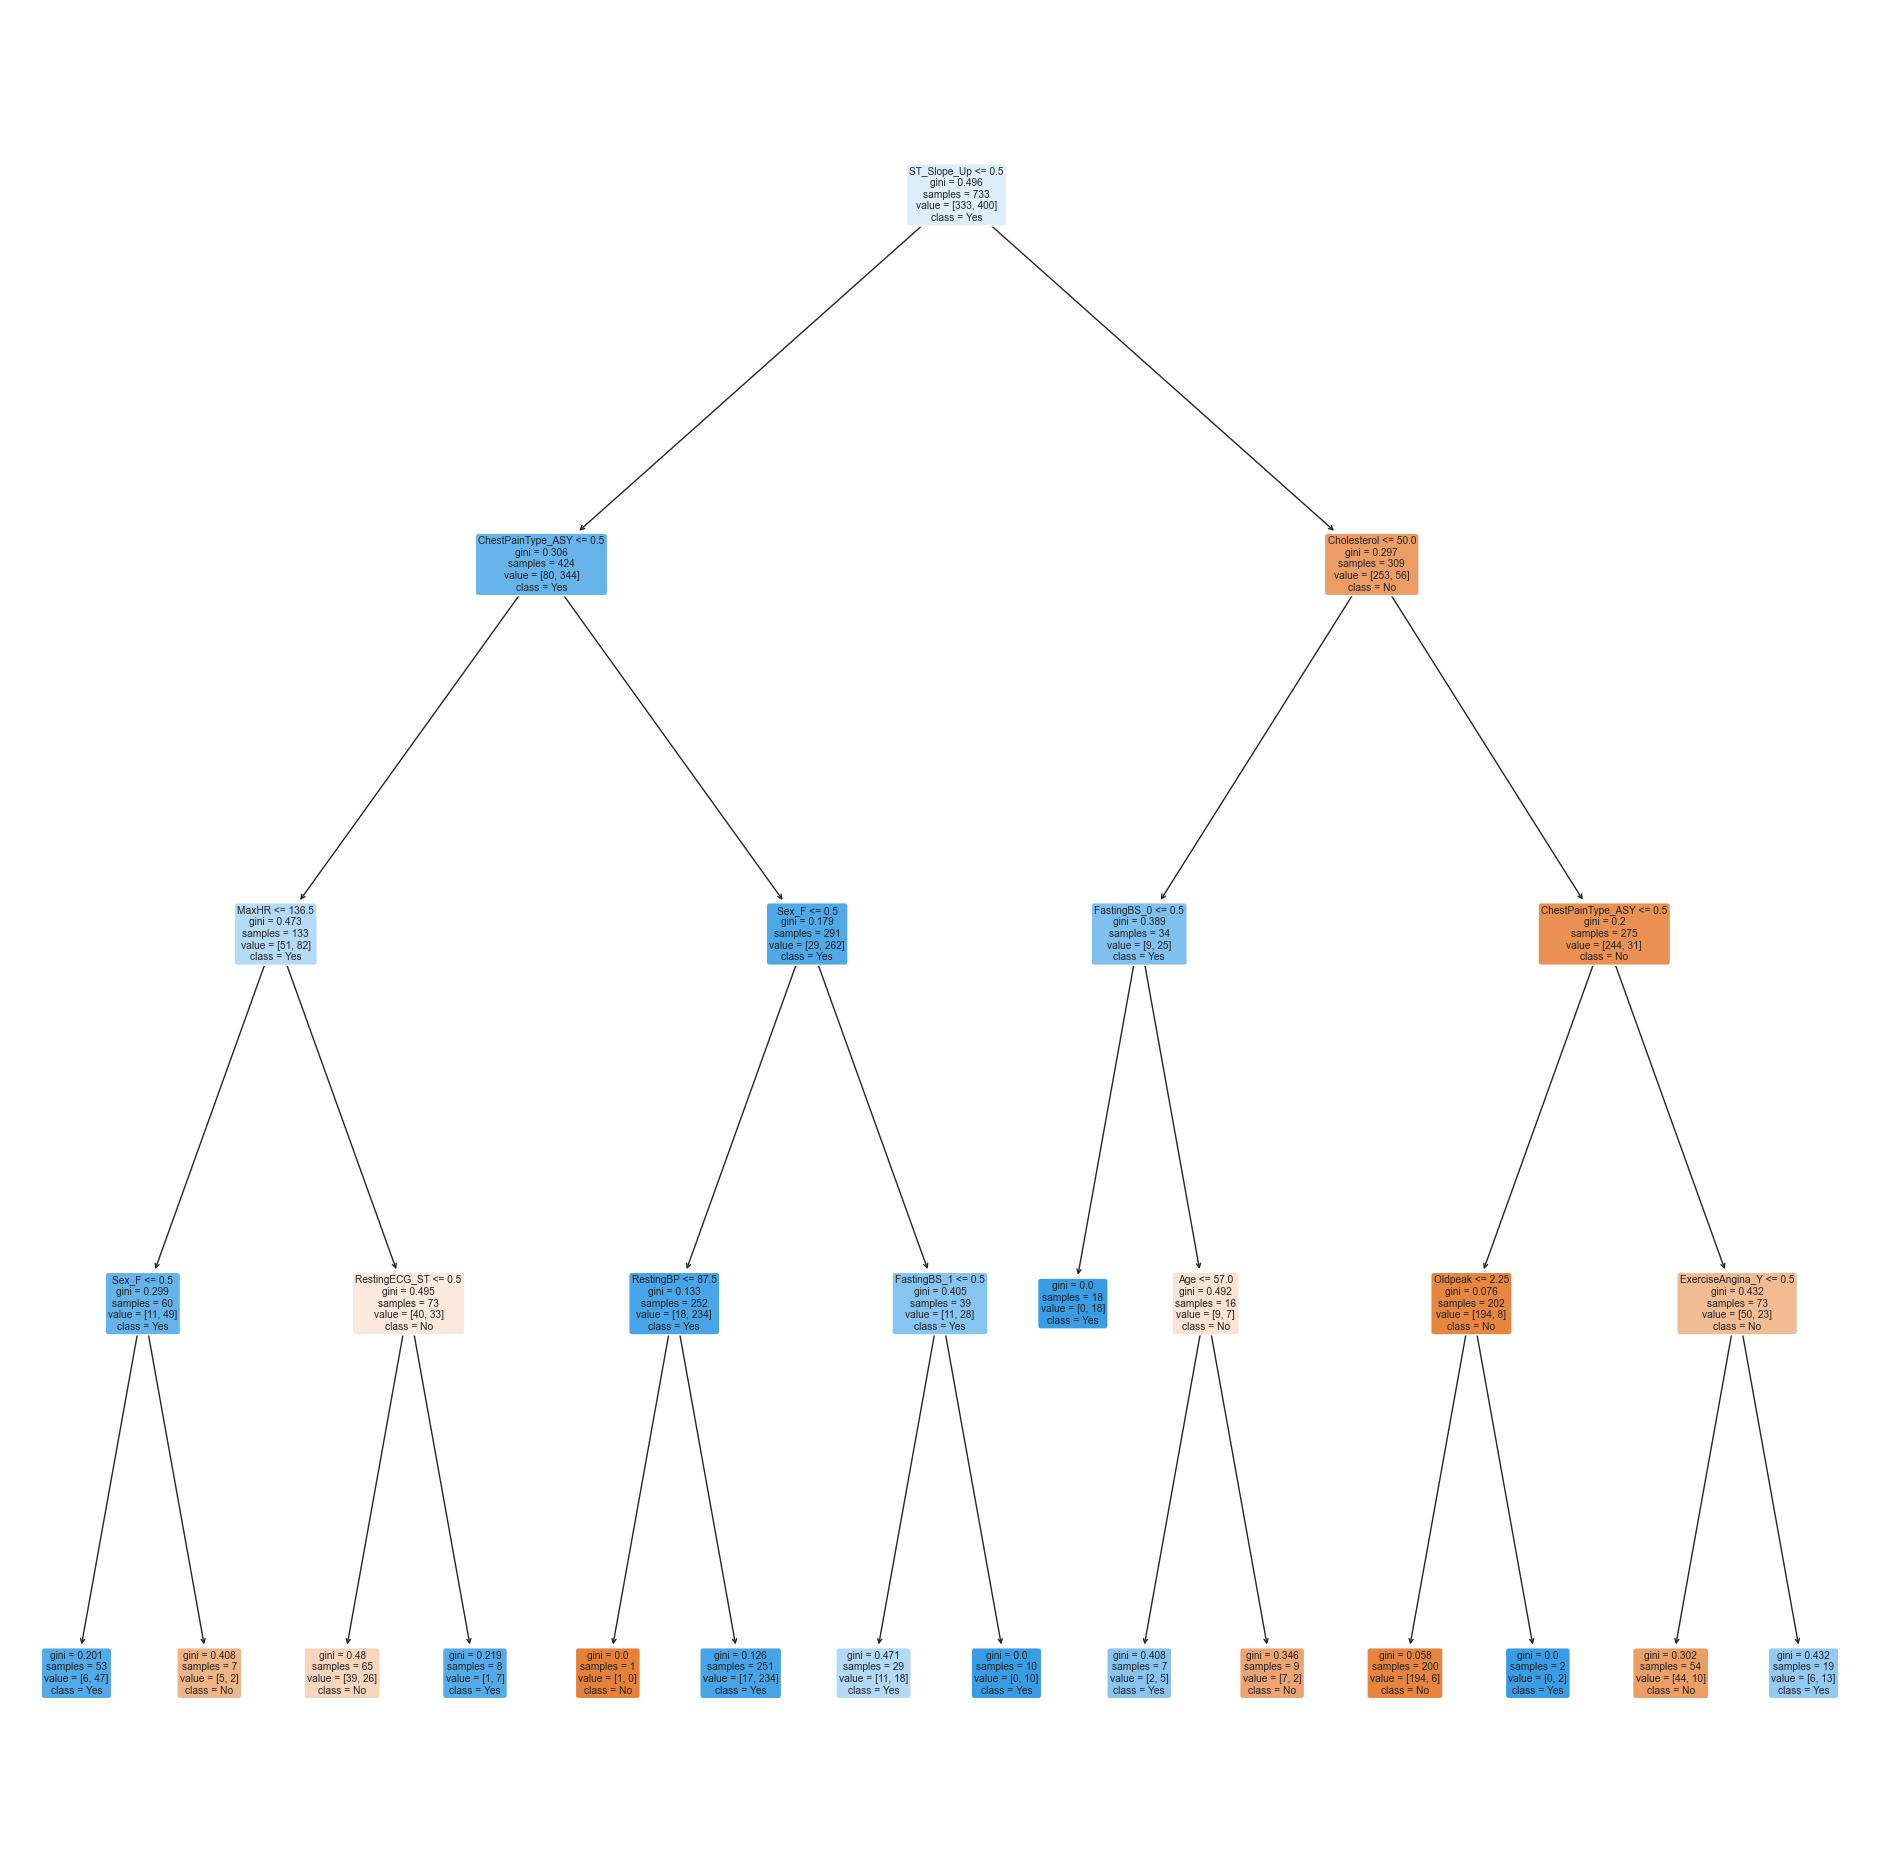

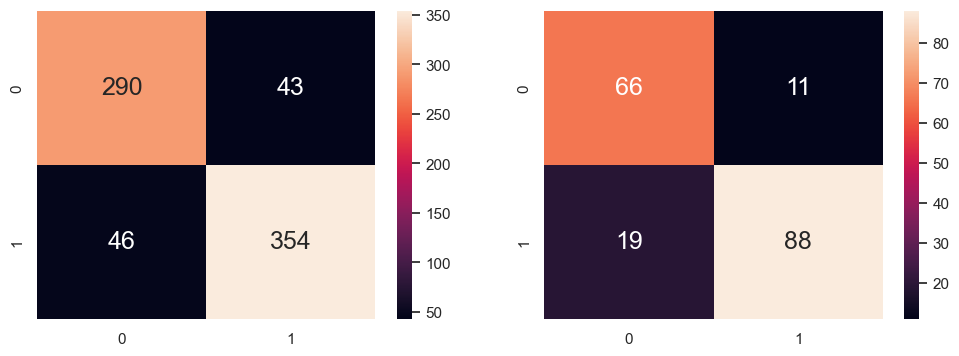

Train Data
              precision    recall  f1-score   support

           0       0.86      0.87      0.87       333
           1       0.89      0.89      0.89       400

    accuracy                           0.88       733
   macro avg       0.88      0.88      0.88       733
weighted avg       0.88      0.88      0.88       733


---------------------------------------------
Test Data
              precision    recall  f1-score   support

           0       0.78      0.86      0.81        77
           1       0.89      0.82      0.85       107

    accuracy                           0.84       184
   macro avg       0.83      0.84      0.83       184
weighted avg       0.84      0.84      0.84       184




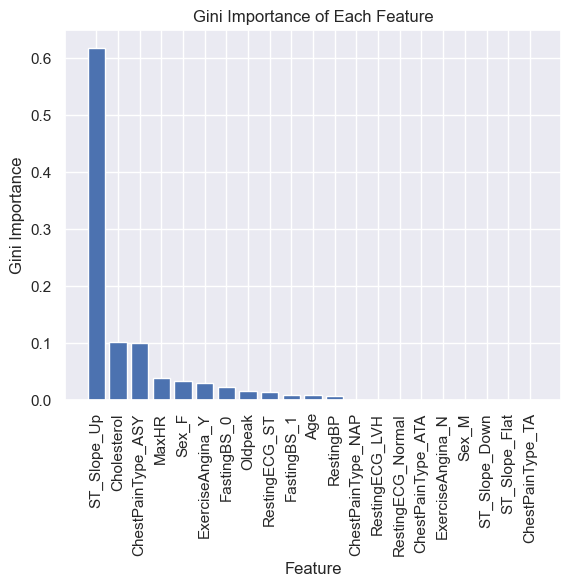

In [10]:
DecTree(best_para, X_train, X_test, y_train, y_test)

### Create a function to repeat the steps above for every model

We would have to implement One Hot Encoding for all of our models. Hence it would be a good idea to create a function to do this for us.

In [11]:
def process(name_df):
    #One hot implementation
    ohe = OneHotEncoder()

    # OneHotEncoding of categorical predictors (not the response)
    name_df_cat = name_df[['Sex','ChestPainType','FastingBS','RestingECG','ExerciseAngina','ST_Slope']]
    ohe.fit(name_df_cat)
    name_df_cat_ohe = pd.DataFrame(ohe.transform(name_df_cat).toarray(), 
                                      columns=ohe.get_feature_names_out(name_df_cat.columns))

    # Check the encoded variables
    #name_df_cat_ohe.info()

    print('')

    # Combining Numeric features with the OHE Categorical features
    name_df_num = name_df[['Age','RestingBP','Cholesterol','MaxHR','Oldpeak']]
    name_df_res = name_df['HeartDisease']
    name_df_ohe = pd.concat([name_df_num, name_df_cat_ohe , name_df_res], 
                               sort = False, axis = 1).reindex(index=name_df_num.index)
    
    # Check the final dataframe
    name_df_ohe.info()
    
    print('')

    # Extract Response and Predictors
    y = pd.DataFrame(name_df_ohe['HeartDisease'])
    X = pd.DataFrame(name_df_ohe.drop('HeartDisease', axis = 1))
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = CONSTANT_SEED)
    
    # Import GridSearch for hyperparameter tuning using Cross-Validation (CV)
    from sklearn.model_selection import GridSearchCV

    # Define the Hyper-parameter Grid to search on, in case of Multi-Variate Classification Tree
    param_grid = {'max_depth': np.arange(2, 11)}             # depth of trees 2, 3, 4, 5, ..., 11

    # Create the Hyper-parameter Grid
    hpGrid = GridSearchCV(DecisionTreeClassifier(random_state = CONSTANT_SEED),   # the model family
                      param_grid,                 # the search grid
                      cv=5,                       # 5-fold cross-validation
                      scoring='f1',               # score to evaluate
                      ) # set random state      

    # Train the models using Cross-Validation
    hpGrid.fit(X_train, y_train.HeartDisease.ravel())
    
    # Fetch the best Model or the best set of Hyper-parameters
    print(hpGrid.best_estimator_)
    
    print('')
    
    # Print the score (accuracy) of the best Model after CV
    print(np.abs(hpGrid.best_score_))

    # get the best parameter
    best_para = hpGrid.best_estimator_
    
    # Decision Tree using Train Data
    best_dectree = hpGrid.best_estimator_
    best_dectree.fit(X_train, y_train)

    # Plot the trained Decision Tree
    f = plt.figure(figsize=(24,24))
    plot_tree(best_dectree, filled=True, rounded=True, 
          feature_names=X_train.columns, 
          class_names=["No","Yes"])

    plt.show()

    # Predict the Response corresponding to Predictors
    y_train_pred = best_dectree.predict(X_train)

    # Predict the Response corresponding to Predictors
    y_test_pred = best_dectree.predict(X_test)

    # Plot the Confusion Matrix for Train and Test
    f, axes = plt.subplots(1, 2, figsize=(12, 4))
    sb.heatmap(confusion_matrix(y_train, y_train_pred),
           annot=True, fmt=".0f", annot_kws={"size": 18}, ax=axes[0])
    sb.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot=True, fmt=".0f", annot_kws={"size": 18}, ax=axes[1])
    plt.show()
    
    #Predict the Response corresponding to Predictors
    y_train_pred = hpGrid.best_estimator_.predict(X_train)

    #Print the Classification Accuracy
    print("Train Data")
    print(classification_report(y_train,y_train_pred))
    print()

    print('---------------------------------------------')

    #Predict the Response corresponding to Predictors
    y_test_pred = hpGrid.best_estimator_.predict(X_test)

    #Print the Classification Accuracy
    print("Test Data")
    print(classification_report(y_test,y_test_pred))
    print()
    
    # Get the Gini importance of all features
    importances = best_dectree.feature_importances_

    # Create a dataframe to store the Gini importance of each feature
    gini_df = pd.DataFrame({'feature': X_train.columns, 'gini_importance': importances})

    # Sort the features by their Gini importance in descending order
    gini_df = gini_df.sort_values('gini_importance', ascending=False)

    # Create a bar plot of the Gini importance of each feature

    plt.bar(gini_df['feature'], gini_df['gini_importance'])
    plt.xticks(rotation=90)
    plt.xlabel('Feature')
    plt.ylabel('Gini Importance')
    plt.title('Gini Importance of Each Feature')
    plt.show()
    
    return

## Imputation

Imputation is a technique used to fill in missing values in a dataset. The purpose of imputation is to make use of as much of the available data as possible, which can improve the accuracy and reliability of machine learning models. <br><br>

Imputation helps to fill in the missing values with estimates based on the available data. The choice of imputation method depends on the nature of the missing data and the statistical properties of the dataset.  <br><br>

There are various methods of imputation, ranging from simple methods such as mean imputation, to more complex methods such as regression imputation or K-nearest neighbors imputation. For this exploration we will focus on mean and median imputation.  <br><br>

By filling in missing values with imputed values, we can reduce the bias and variability of our estimates, and improve the performance of machine learning models. However, it is important to note that imputation introduces some uncertainty into the dataset, and the choice of imputation method can affect the accuracy and reliability of the results  <br><br>

### Create a function to impute values

In [12]:
def imputer(name_df, method):

    # create SimpleImputer object
    imputer = SimpleImputer(missing_values=0, strategy=method)

    # fit imputer to 'cholesterol' column
    imputer.fit(name_df[['Cholesterol']])

    # transform 'cholesterol' column by replacing 0 with mean value
    name_df['Cholesterol'] = imputer.transform(name_df[['Cholesterol']])
    
    return name_df

### Model 2: IPmean_heart_df (Mean imputation / With outliers)

In [13]:
#Impute mean for every '0' value in Choelestrol
IPmean_heart_df = main_heart_df.copy()
IPmean_heart_df = imputer(IPmean_heart_df, 'mean')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 917 entries, 0 to 916
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                917 non-null    int64  
 1   RestingBP          917 non-null    int64  
 2   Cholesterol        917 non-null    float64
 3   MaxHR              917 non-null    int64  
 4   Oldpeak            917 non-null    float64
 5   Sex_F              917 non-null    float64
 6   Sex_M              917 non-null    float64
 7   ChestPainType_ASY  917 non-null    float64
 8   ChestPainType_ATA  917 non-null    float64
 9   ChestPainType_NAP  917 non-null    float64
 10  ChestPainType_TA   917 non-null    float64
 11  FastingBS_0        917 non-null    float64
 12  FastingBS_1        917 non-null    float64
 13  RestingECG_LVH     917 non-null    float64
 14  RestingECG_Normal  917 non-null    float64
 15  RestingECG_ST      917 non-null    float64
 16  ExerciseAngina_N   917 no

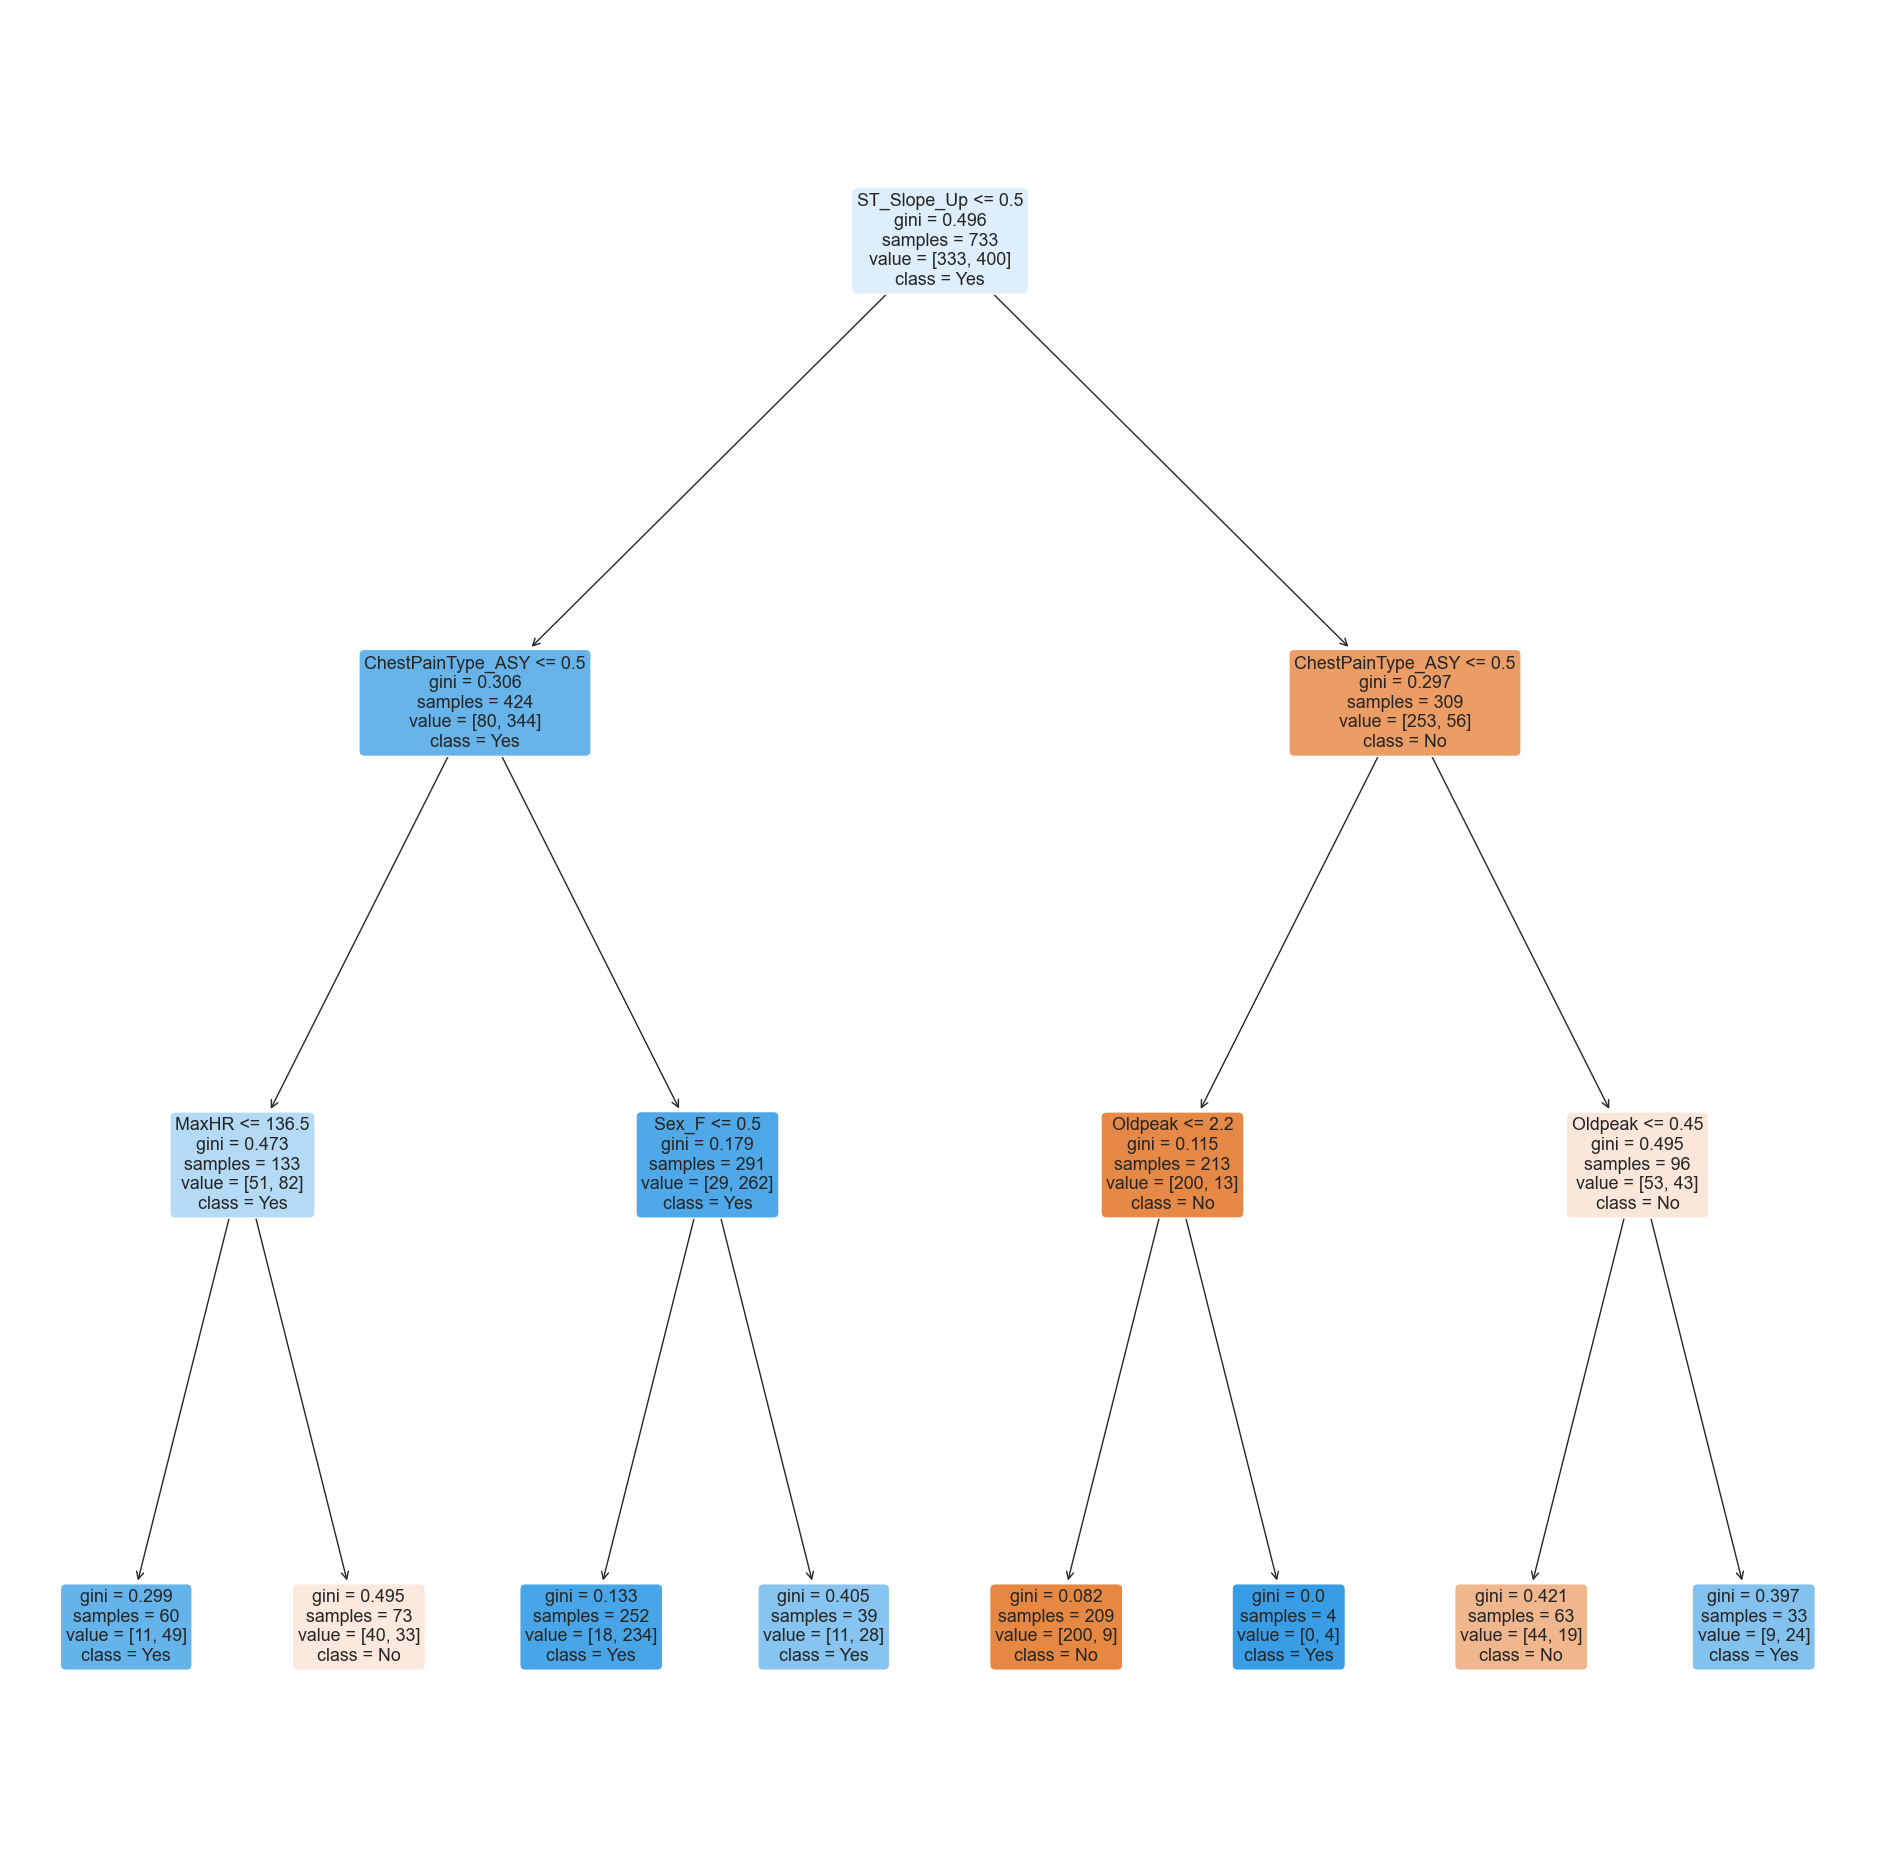

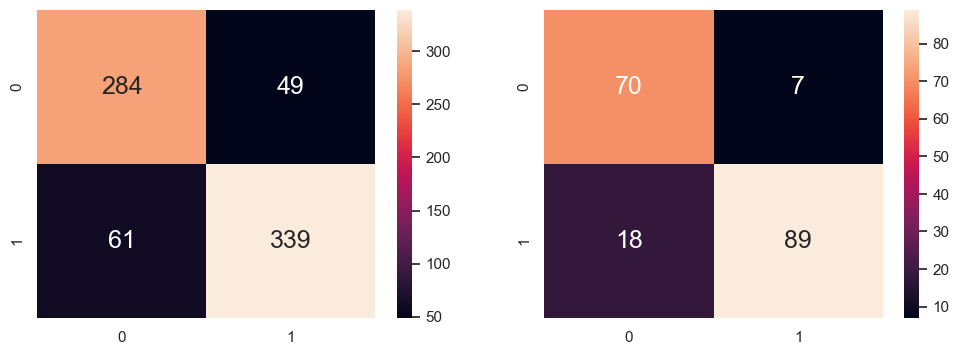

Train Data
              precision    recall  f1-score   support

           0       0.82      0.85      0.84       333
           1       0.87      0.85      0.86       400

    accuracy                           0.85       733
   macro avg       0.85      0.85      0.85       733
weighted avg       0.85      0.85      0.85       733


---------------------------------------------
Test Data
              precision    recall  f1-score   support

           0       0.80      0.91      0.85        77
           1       0.93      0.83      0.88       107

    accuracy                           0.86       184
   macro avg       0.86      0.87      0.86       184
weighted avg       0.87      0.86      0.86       184




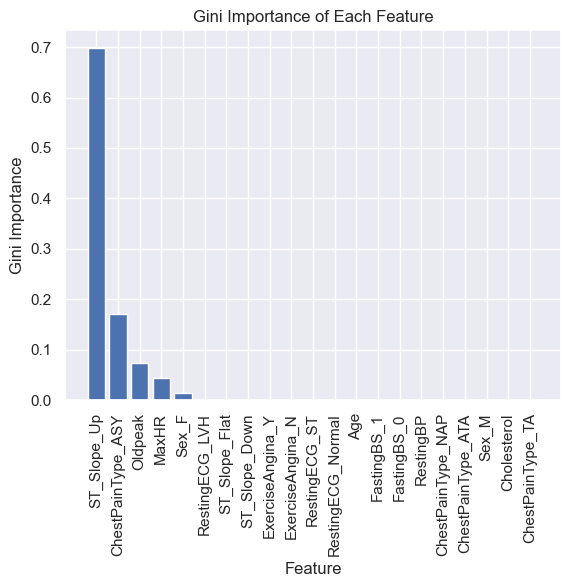

In [14]:
process(IPmean_heart_df)

### Model 3: IPmedian_heart_df (Median imputation / With outliers)¶

In [15]:
#Impute median for every '0' value in Choelestrol
IPmedian_heart_df = main_heart_df.copy()
IPmedian_heart_df = imputer(IPmedian_heart_df, 'median')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 917 entries, 0 to 916
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                917 non-null    int64  
 1   RestingBP          917 non-null    int64  
 2   Cholesterol        917 non-null    float64
 3   MaxHR              917 non-null    int64  
 4   Oldpeak            917 non-null    float64
 5   Sex_F              917 non-null    float64
 6   Sex_M              917 non-null    float64
 7   ChestPainType_ASY  917 non-null    float64
 8   ChestPainType_ATA  917 non-null    float64
 9   ChestPainType_NAP  917 non-null    float64
 10  ChestPainType_TA   917 non-null    float64
 11  FastingBS_0        917 non-null    float64
 12  FastingBS_1        917 non-null    float64
 13  RestingECG_LVH     917 non-null    float64
 14  RestingECG_Normal  917 non-null    float64
 15  RestingECG_ST      917 non-null    float64
 16  ExerciseAngina_N   917 no

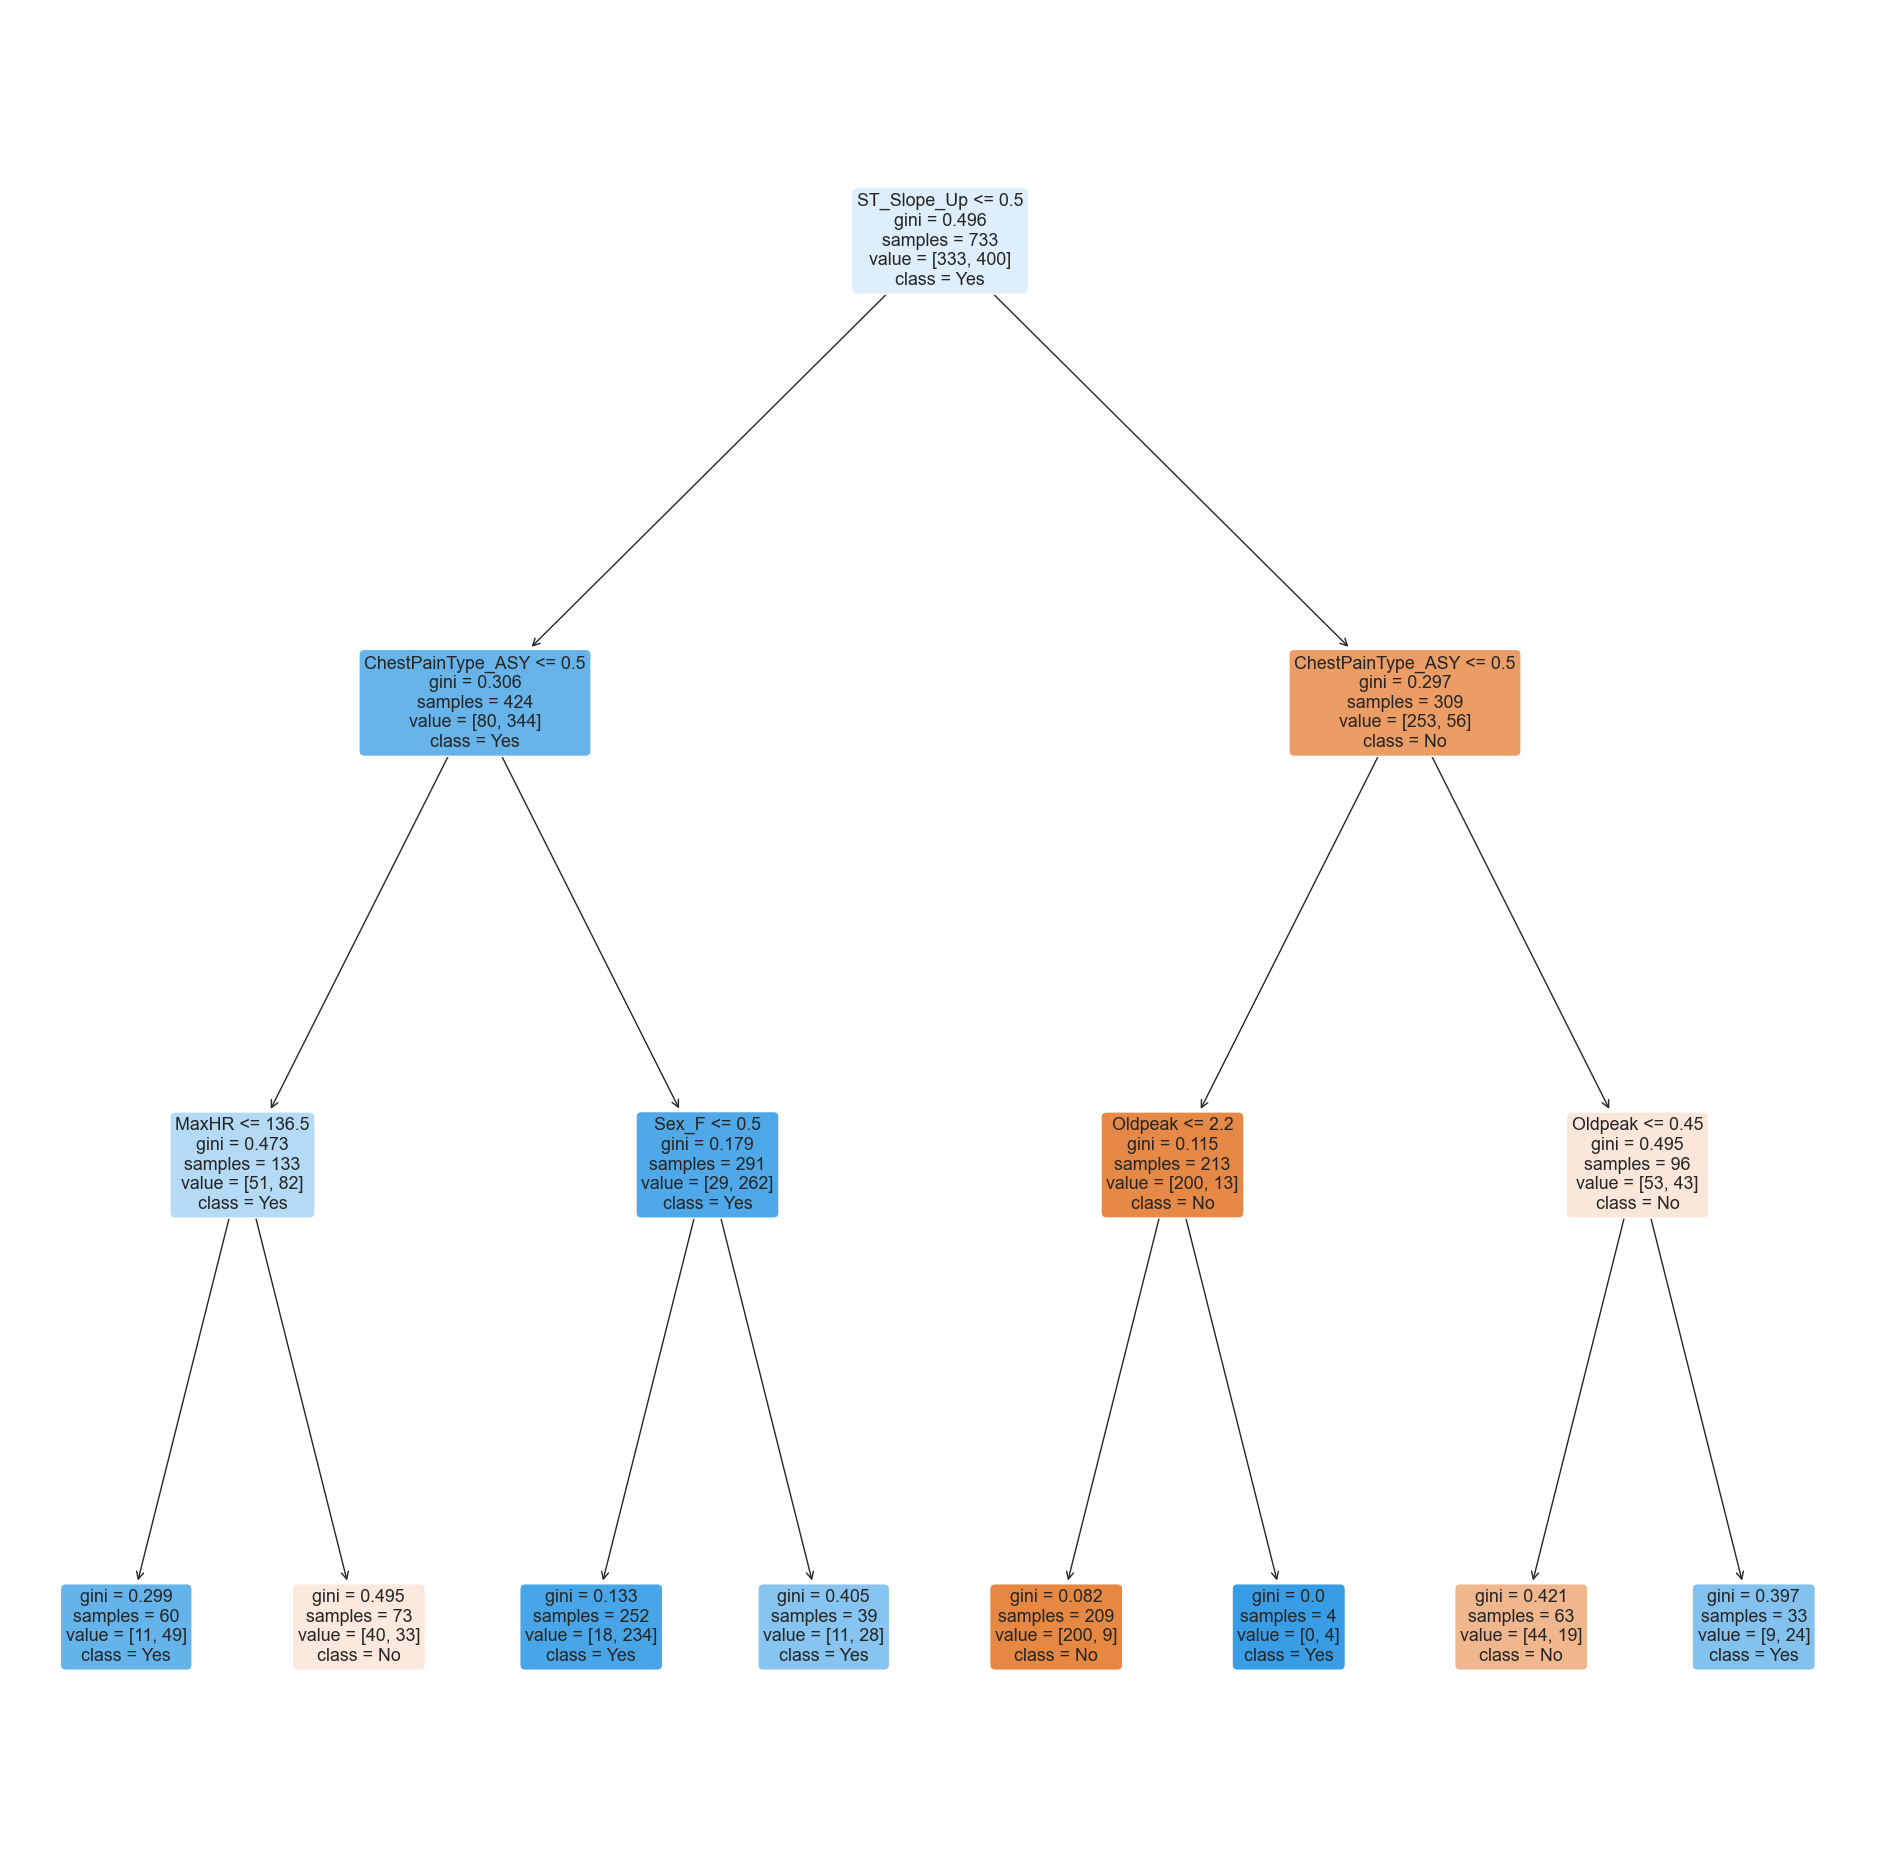

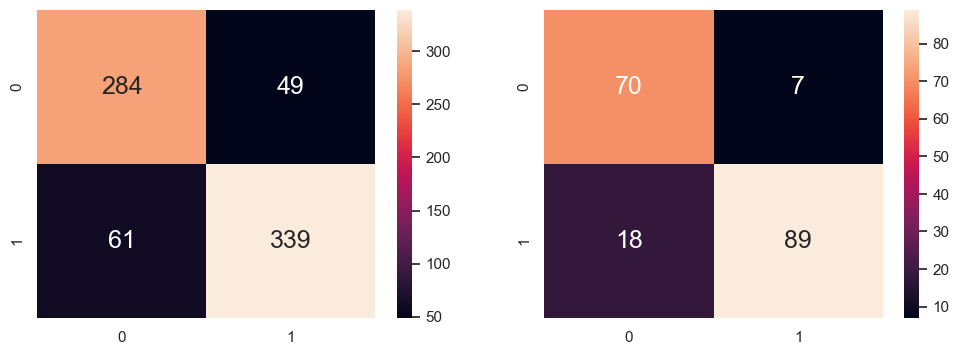

Train Data
              precision    recall  f1-score   support

           0       0.82      0.85      0.84       333
           1       0.87      0.85      0.86       400

    accuracy                           0.85       733
   macro avg       0.85      0.85      0.85       733
weighted avg       0.85      0.85      0.85       733


---------------------------------------------
Test Data
              precision    recall  f1-score   support

           0       0.80      0.91      0.85        77
           1       0.93      0.83      0.88       107

    accuracy                           0.86       184
   macro avg       0.86      0.87      0.86       184
weighted avg       0.87      0.86      0.86       184




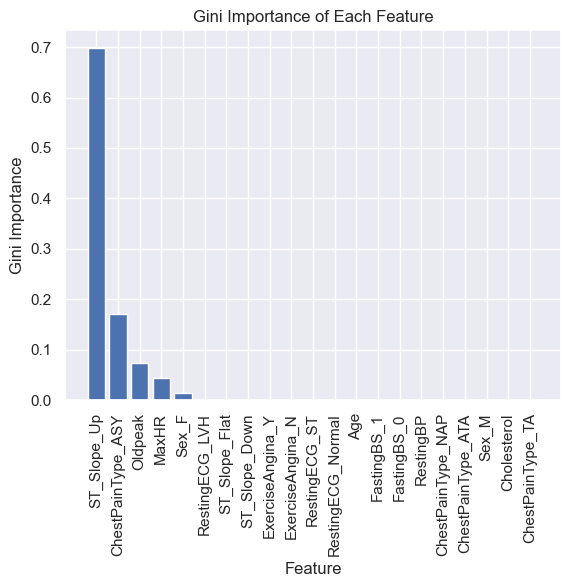

In [16]:
process(IPmedian_heart_df)

## Handle Outliers

### Create a function to remove outliers

In [17]:
# define a function called "Outliers" which returns a list of outliers 
# IQR = Q3-Q1
# +/- 1.5* IQR

def remove_outliers(name_df):
    num_cols = name_df.select_dtypes(include=[np.number]).columns
    cat_cols = name_df.select_dtypes(exclude=[np.number]).columns
    
    Q1 = name_df[num_cols].quantile(0.25)
    Q3 = name_df[num_cols].quantile(0.75)
    
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outlier_mask = ((name_df[num_cols] < lower_bound) | (name_df[num_cols] > upper_bound)).any(axis=1)
    
    return name_df.loc[~outlier_mask, :]

### Model 4: IPzero_N0_outliers_heart_df (No imputation / Without outliers)¶

Lets try removing the outliers in the Dataset to see if it will improve the accuracy in the test set. 

In [18]:
# Deleting Outliers and creating new Dataframe IPzero_N0_outliers_heart_df
IPzero_N0_outliers_heart_df = main_heart_df.copy()
IPzero_N0_outliers_heart_df = remove_outliers(IPzero_N0_outliers_heart_df).reset_index(drop=True)

In [19]:
IPzero_N0_outliers_heart_df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
583,57,F,ASY,140,241,0,Normal,123,Y,0.2,Flat,1
584,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
585,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
586,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588 entries, 0 to 587
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                588 non-null    int64  
 1   RestingBP          588 non-null    int64  
 2   Cholesterol        588 non-null    int64  
 3   MaxHR              588 non-null    int64  
 4   Oldpeak            588 non-null    float64
 5   Sex_F              588 non-null    float64
 6   Sex_M              588 non-null    float64
 7   ChestPainType_ASY  588 non-null    float64
 8   ChestPainType_ATA  588 non-null    float64
 9   ChestPainType_NAP  588 non-null    float64
 10  ChestPainType_TA   588 non-null    float64
 11  FastingBS_0        588 non-null    float64
 12  RestingECG_LVH     588 non-null    float64
 13  RestingECG_Normal  588 non-null    float64
 14  RestingECG_ST      588 non-null    float64
 15  ExerciseAngina_N   588 non-null    float64
 16  ExerciseAngina_Y   588 no

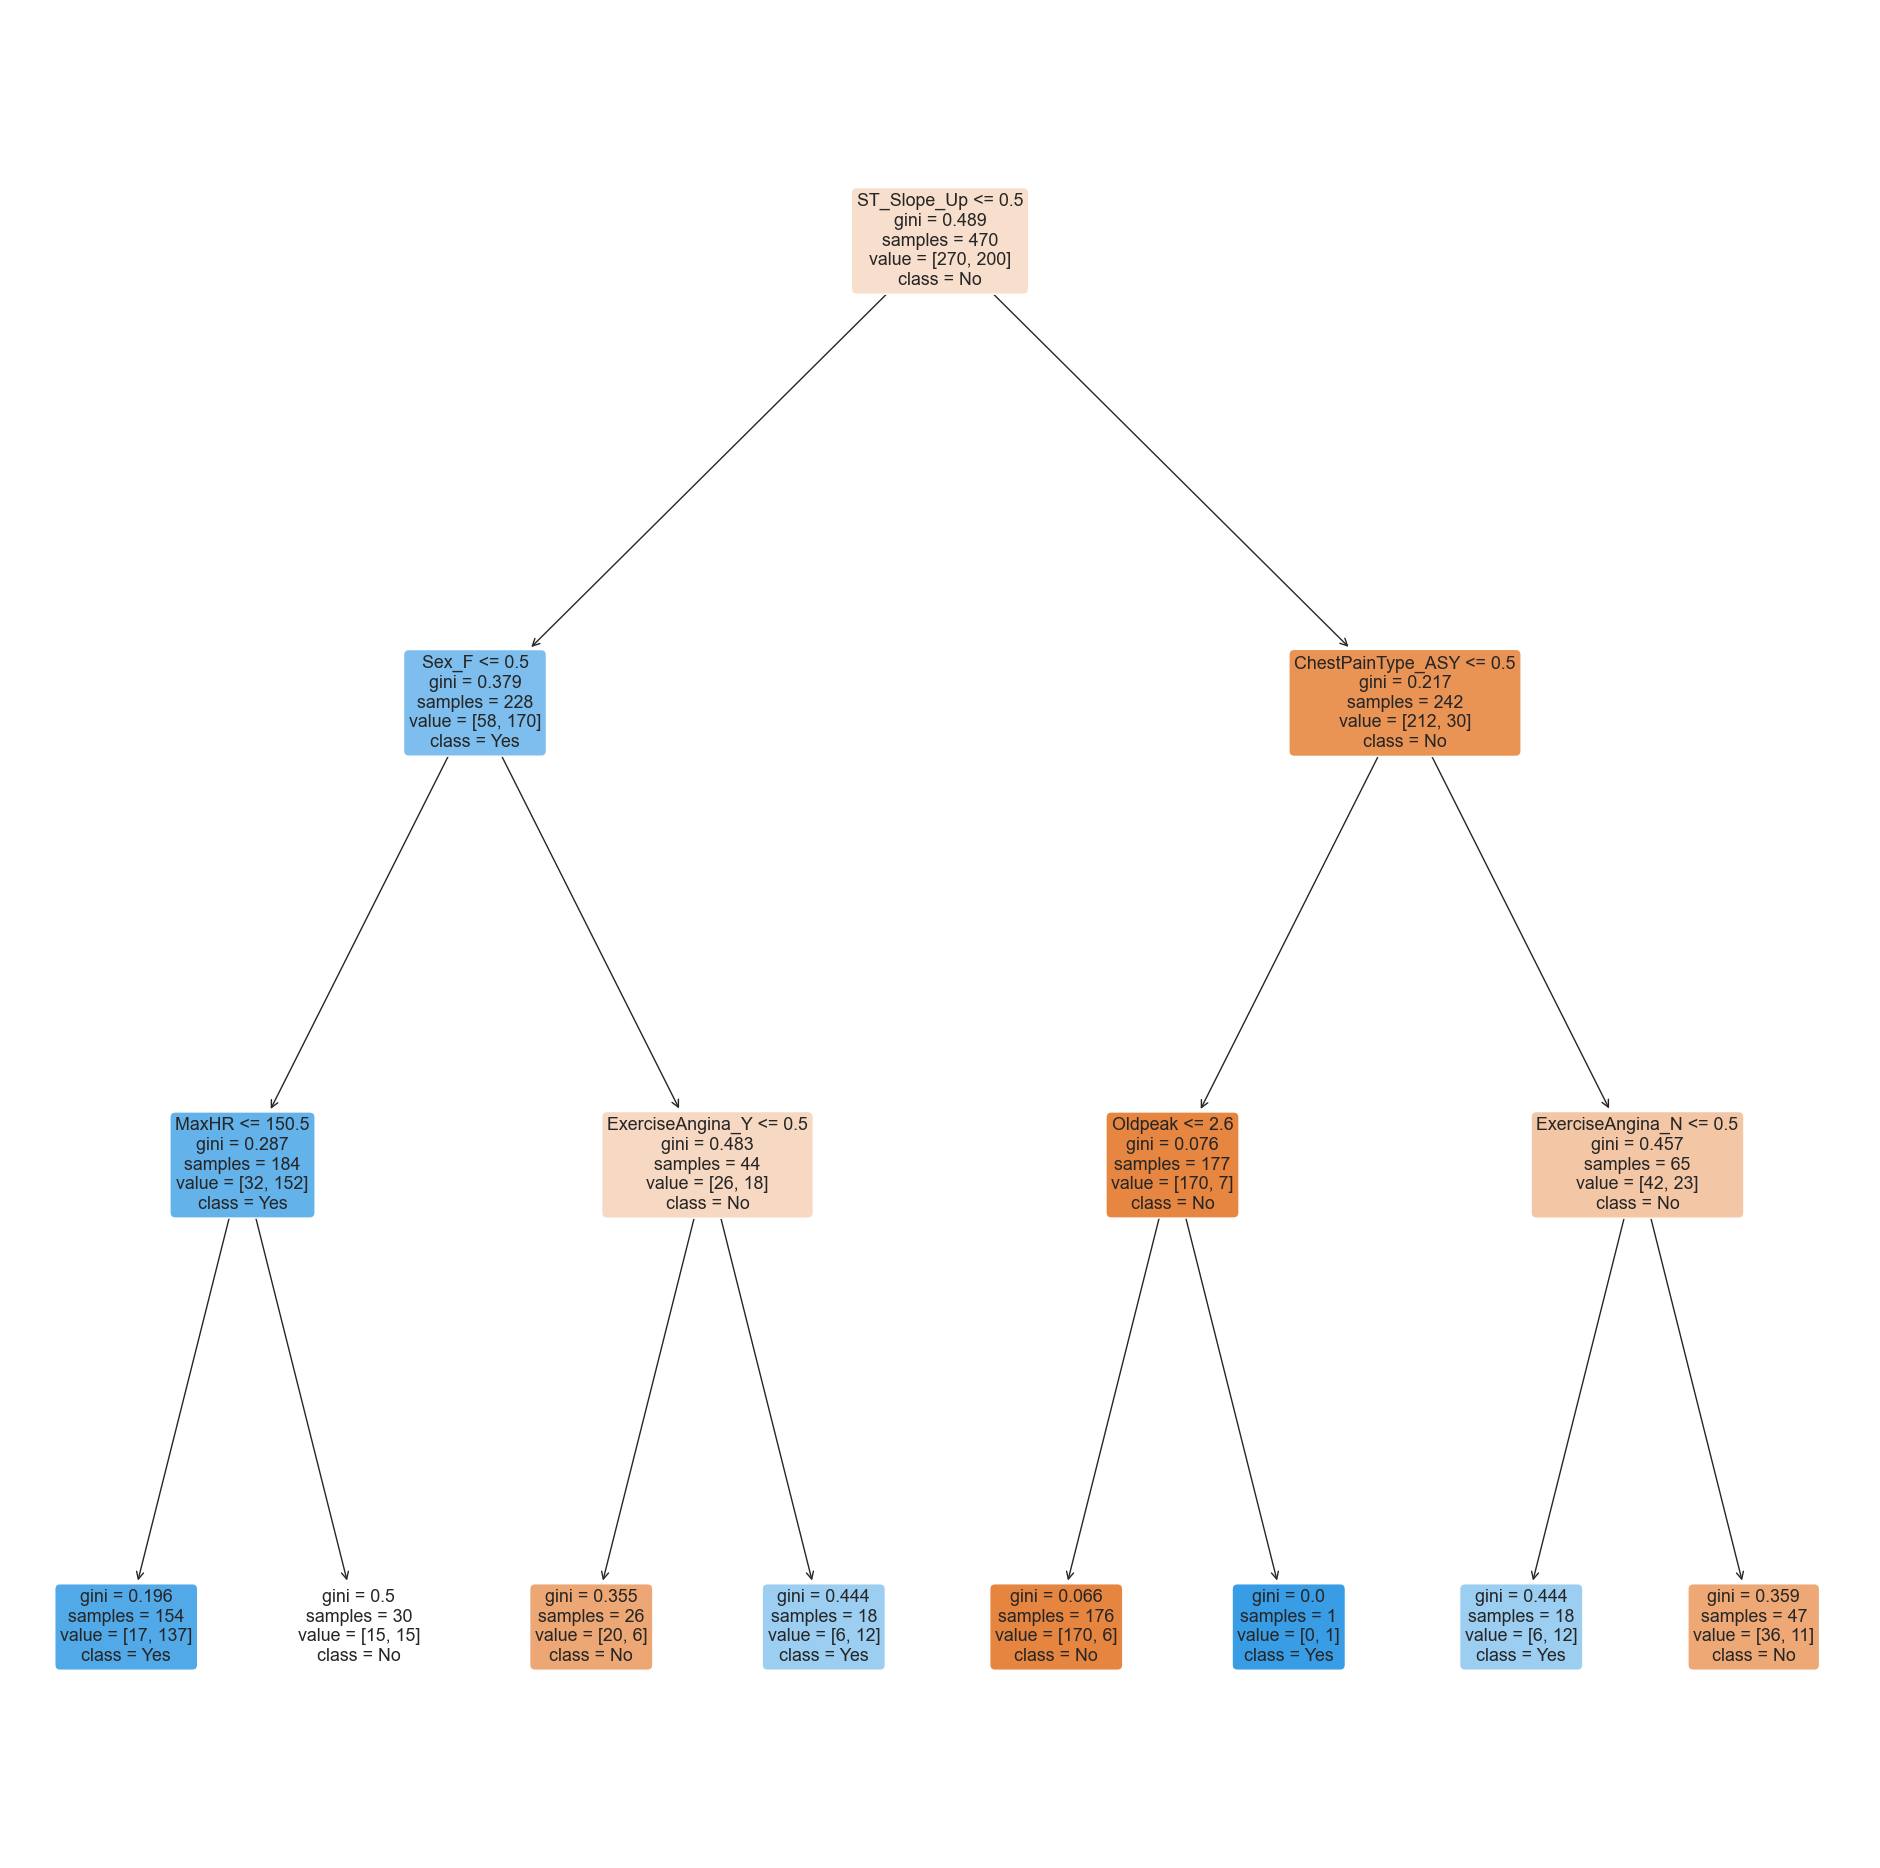

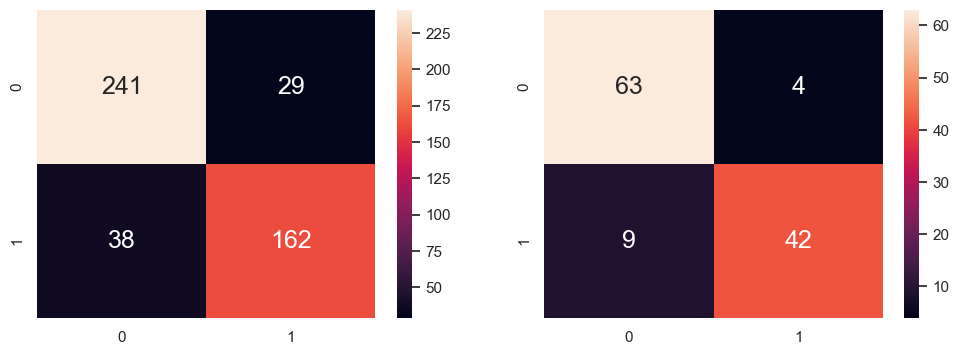

Train Data
              precision    recall  f1-score   support

           0       0.86      0.89      0.88       270
           1       0.85      0.81      0.83       200

    accuracy                           0.86       470
   macro avg       0.86      0.85      0.85       470
weighted avg       0.86      0.86      0.86       470


---------------------------------------------
Test Data
              precision    recall  f1-score   support

           0       0.88      0.94      0.91        67
           1       0.91      0.82      0.87        51

    accuracy                           0.89       118
   macro avg       0.89      0.88      0.89       118
weighted avg       0.89      0.89      0.89       118




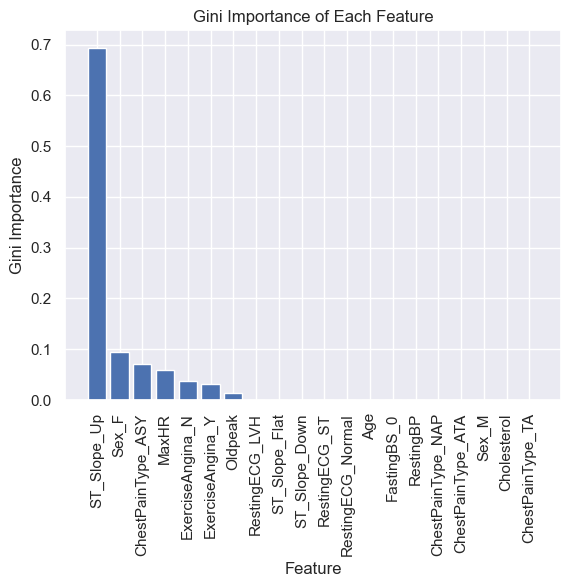

In [20]:
process(IPzero_N0_outliers_heart_df)

### Model 5: IPmean_N0_outliers_heart_df (Mean imputation / Without outliers)

In [21]:
# Deleting Outliers and creating new Dataframe IPmean_N0_outliers_heart_df
IPmean_N0_outliers_heart_df = main_heart_df.copy()

#Impute mean for every '0' value in Choelestrol
IPmean_N0_outliers_heart_df = imputer(IPmean_N0_outliers_heart_df, 'mean')

#Remove outliers 
IPmean_N0_outliers_heart_df = remove_outliers(IPmean_N0_outliers_heart_df).reset_index(drop=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 642 entries, 0 to 641
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                642 non-null    int64  
 1   RestingBP          642 non-null    int64  
 2   Cholesterol        642 non-null    float64
 3   MaxHR              642 non-null    int64  
 4   Oldpeak            642 non-null    float64
 5   Sex_F              642 non-null    float64
 6   Sex_M              642 non-null    float64
 7   ChestPainType_ASY  642 non-null    float64
 8   ChestPainType_ATA  642 non-null    float64
 9   ChestPainType_NAP  642 non-null    float64
 10  ChestPainType_TA   642 non-null    float64
 11  FastingBS_0        642 non-null    float64
 12  RestingECG_LVH     642 non-null    float64
 13  RestingECG_Normal  642 non-null    float64
 14  RestingECG_ST      642 non-null    float64
 15  ExerciseAngina_N   642 non-null    float64
 16  ExerciseAngina_Y   642 no

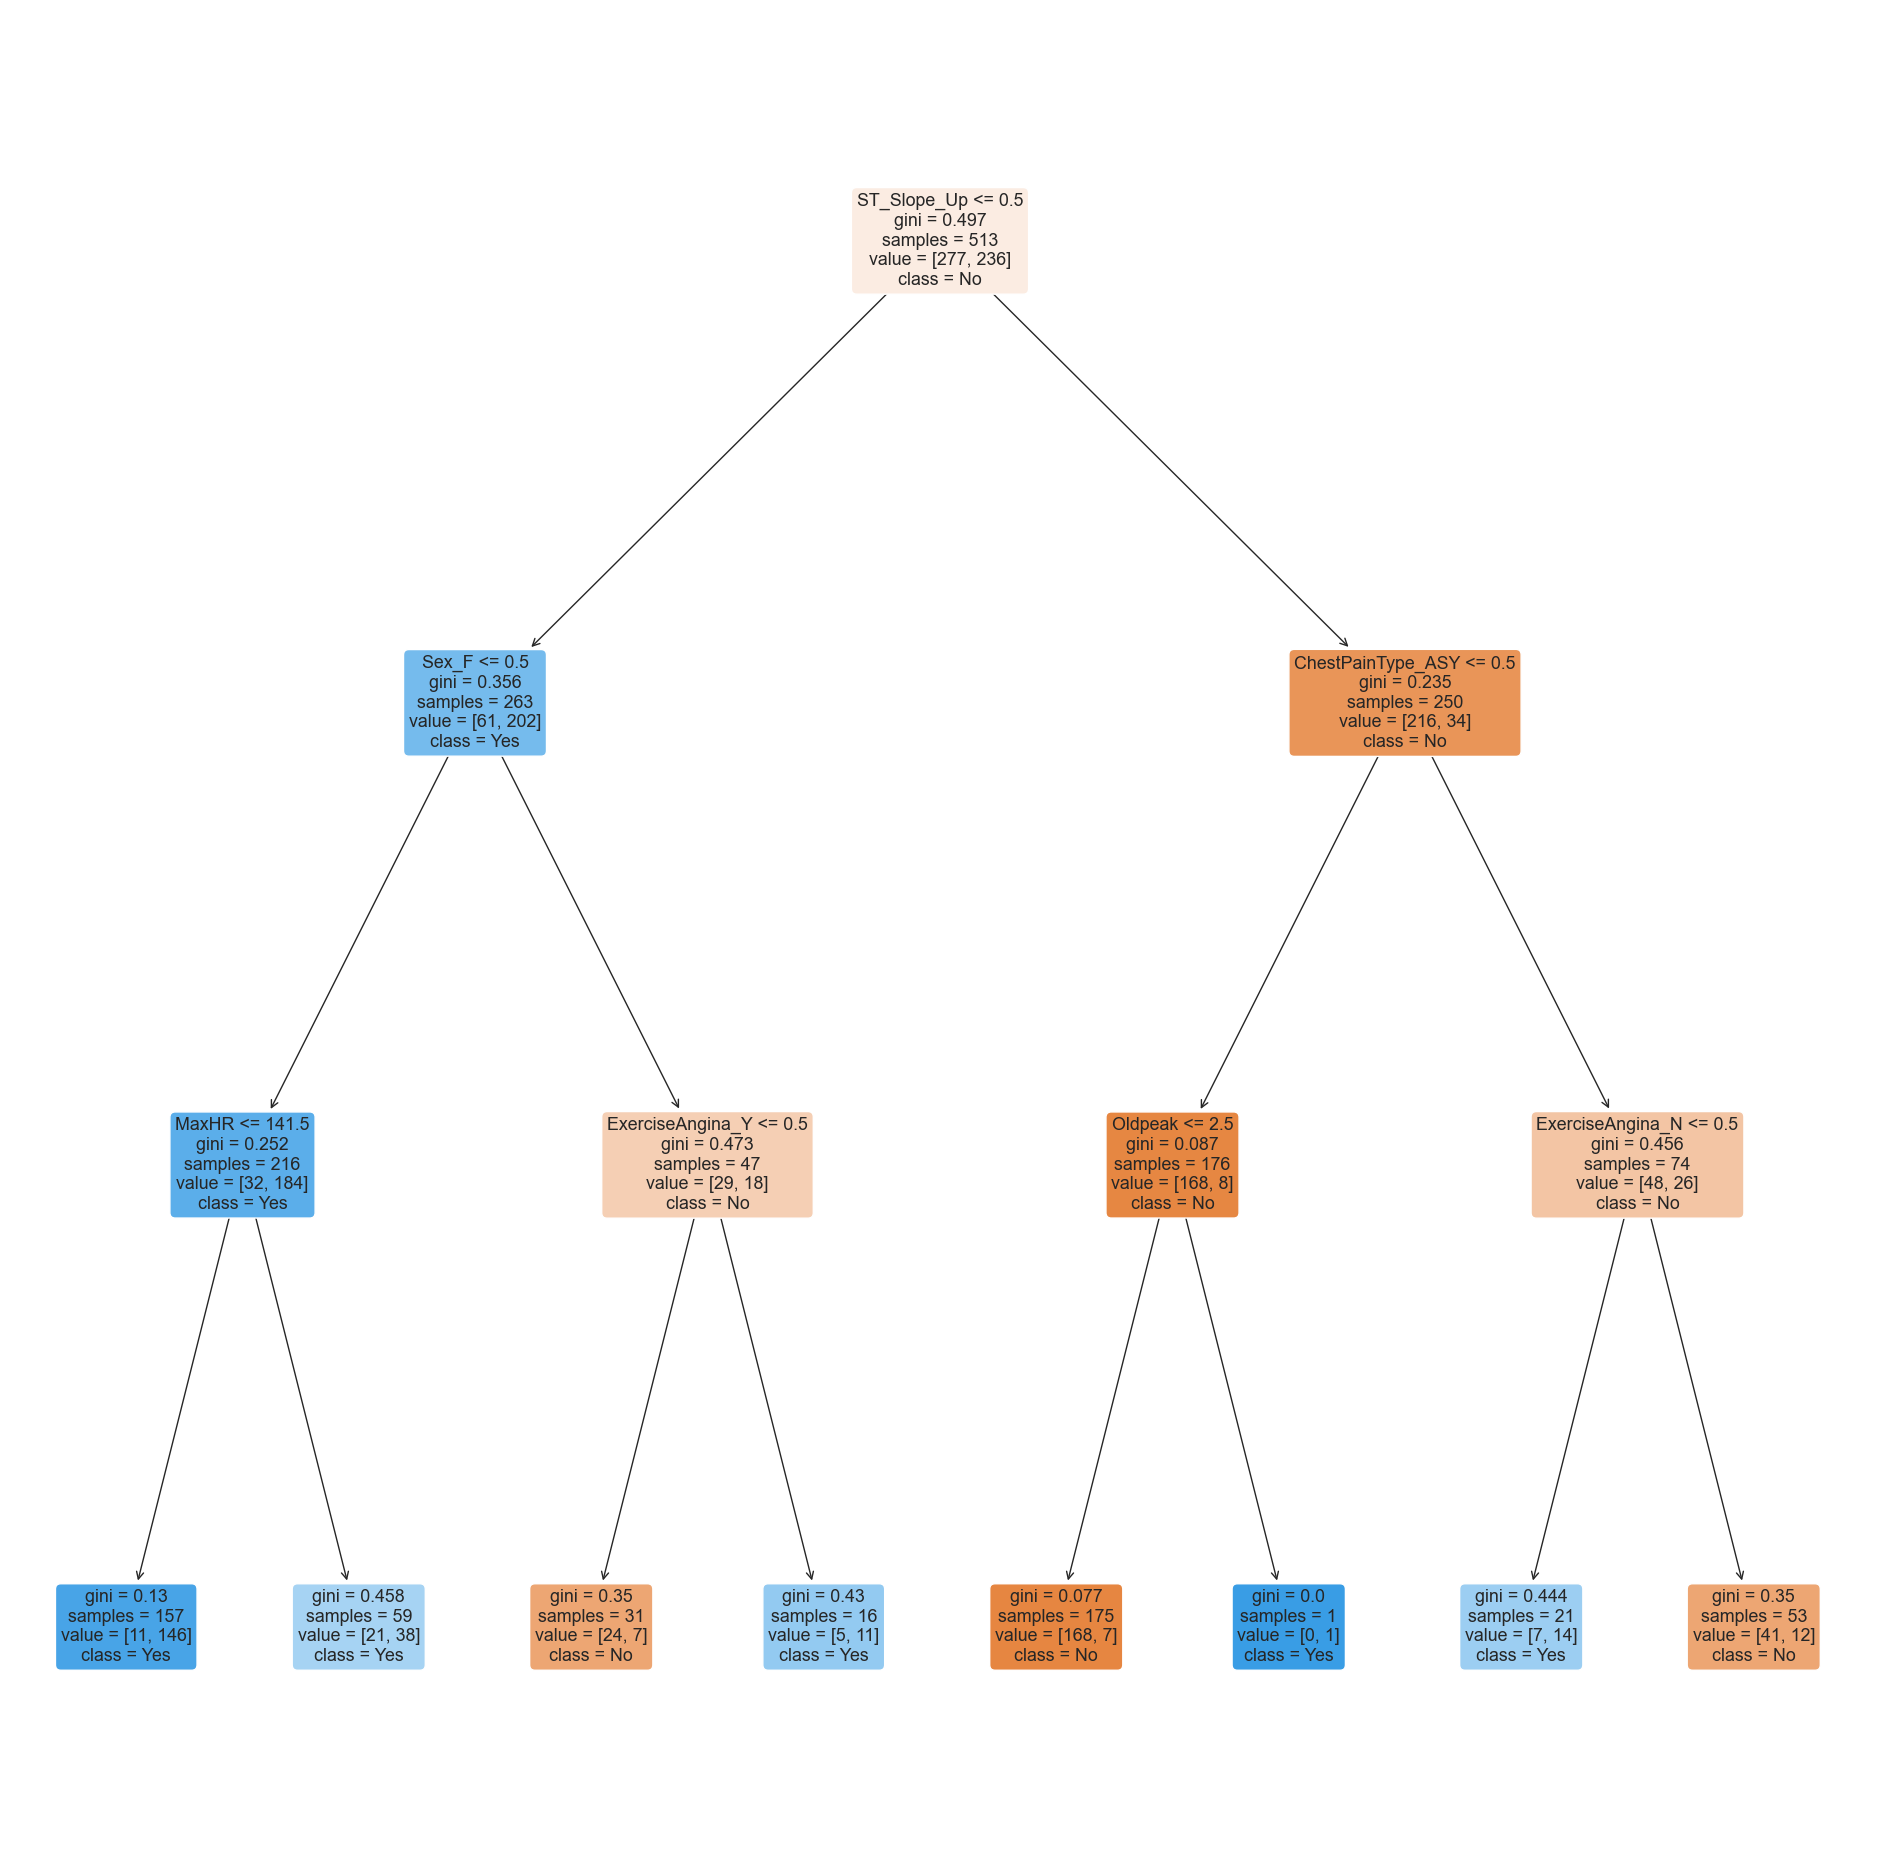

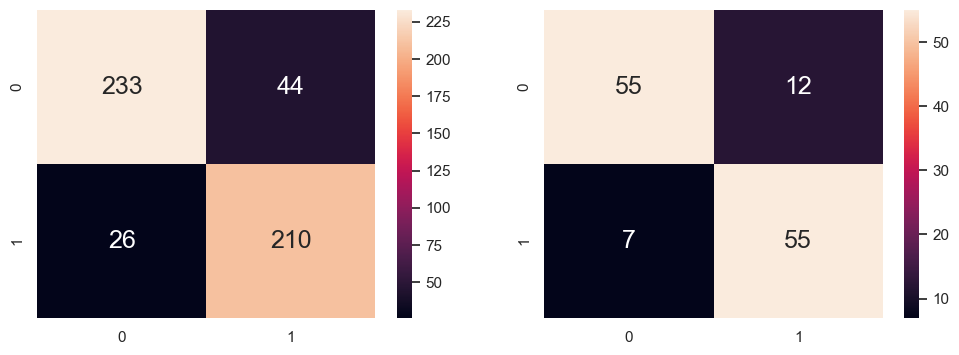

Train Data
              precision    recall  f1-score   support

           0       0.90      0.84      0.87       277
           1       0.83      0.89      0.86       236

    accuracy                           0.86       513
   macro avg       0.86      0.87      0.86       513
weighted avg       0.87      0.86      0.86       513


---------------------------------------------
Test Data
              precision    recall  f1-score   support

           0       0.89      0.82      0.85        67
           1       0.82      0.89      0.85        62

    accuracy                           0.85       129
   macro avg       0.85      0.85      0.85       129
weighted avg       0.86      0.85      0.85       129




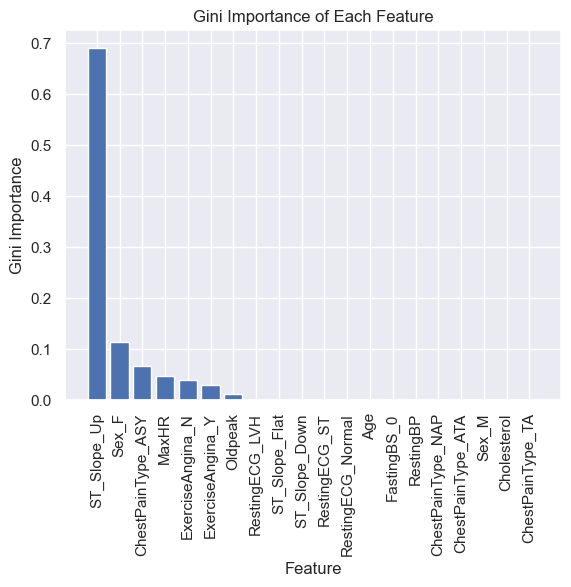

In [22]:
process(IPmean_N0_outliers_heart_df)

### Model 6: IPmedian_N0_outliers_heart_df (Median imputation / Without outliers)

In [23]:
# Deleting Outliers and creating new Dataframe IPmedian_N0_outliers_heart_df
IPmedian_N0_outliers_heart_df = main_heart_df.copy()

#Impute median for every '0' value in Choelestrol
IPmedian_N0_outliers_heart_df = imputer(IPmedian_N0_outliers_heart_df, 'median')

#Remove outliers 
IPmedian_N0_outliers_heart_df = remove_outliers(IPmedian_N0_outliers_heart_df).reset_index(drop=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 642 entries, 0 to 641
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                642 non-null    int64  
 1   RestingBP          642 non-null    int64  
 2   Cholesterol        642 non-null    float64
 3   MaxHR              642 non-null    int64  
 4   Oldpeak            642 non-null    float64
 5   Sex_F              642 non-null    float64
 6   Sex_M              642 non-null    float64
 7   ChestPainType_ASY  642 non-null    float64
 8   ChestPainType_ATA  642 non-null    float64
 9   ChestPainType_NAP  642 non-null    float64
 10  ChestPainType_TA   642 non-null    float64
 11  FastingBS_0        642 non-null    float64
 12  RestingECG_LVH     642 non-null    float64
 13  RestingECG_Normal  642 non-null    float64
 14  RestingECG_ST      642 non-null    float64
 15  ExerciseAngina_N   642 non-null    float64
 16  ExerciseAngina_Y   642 no

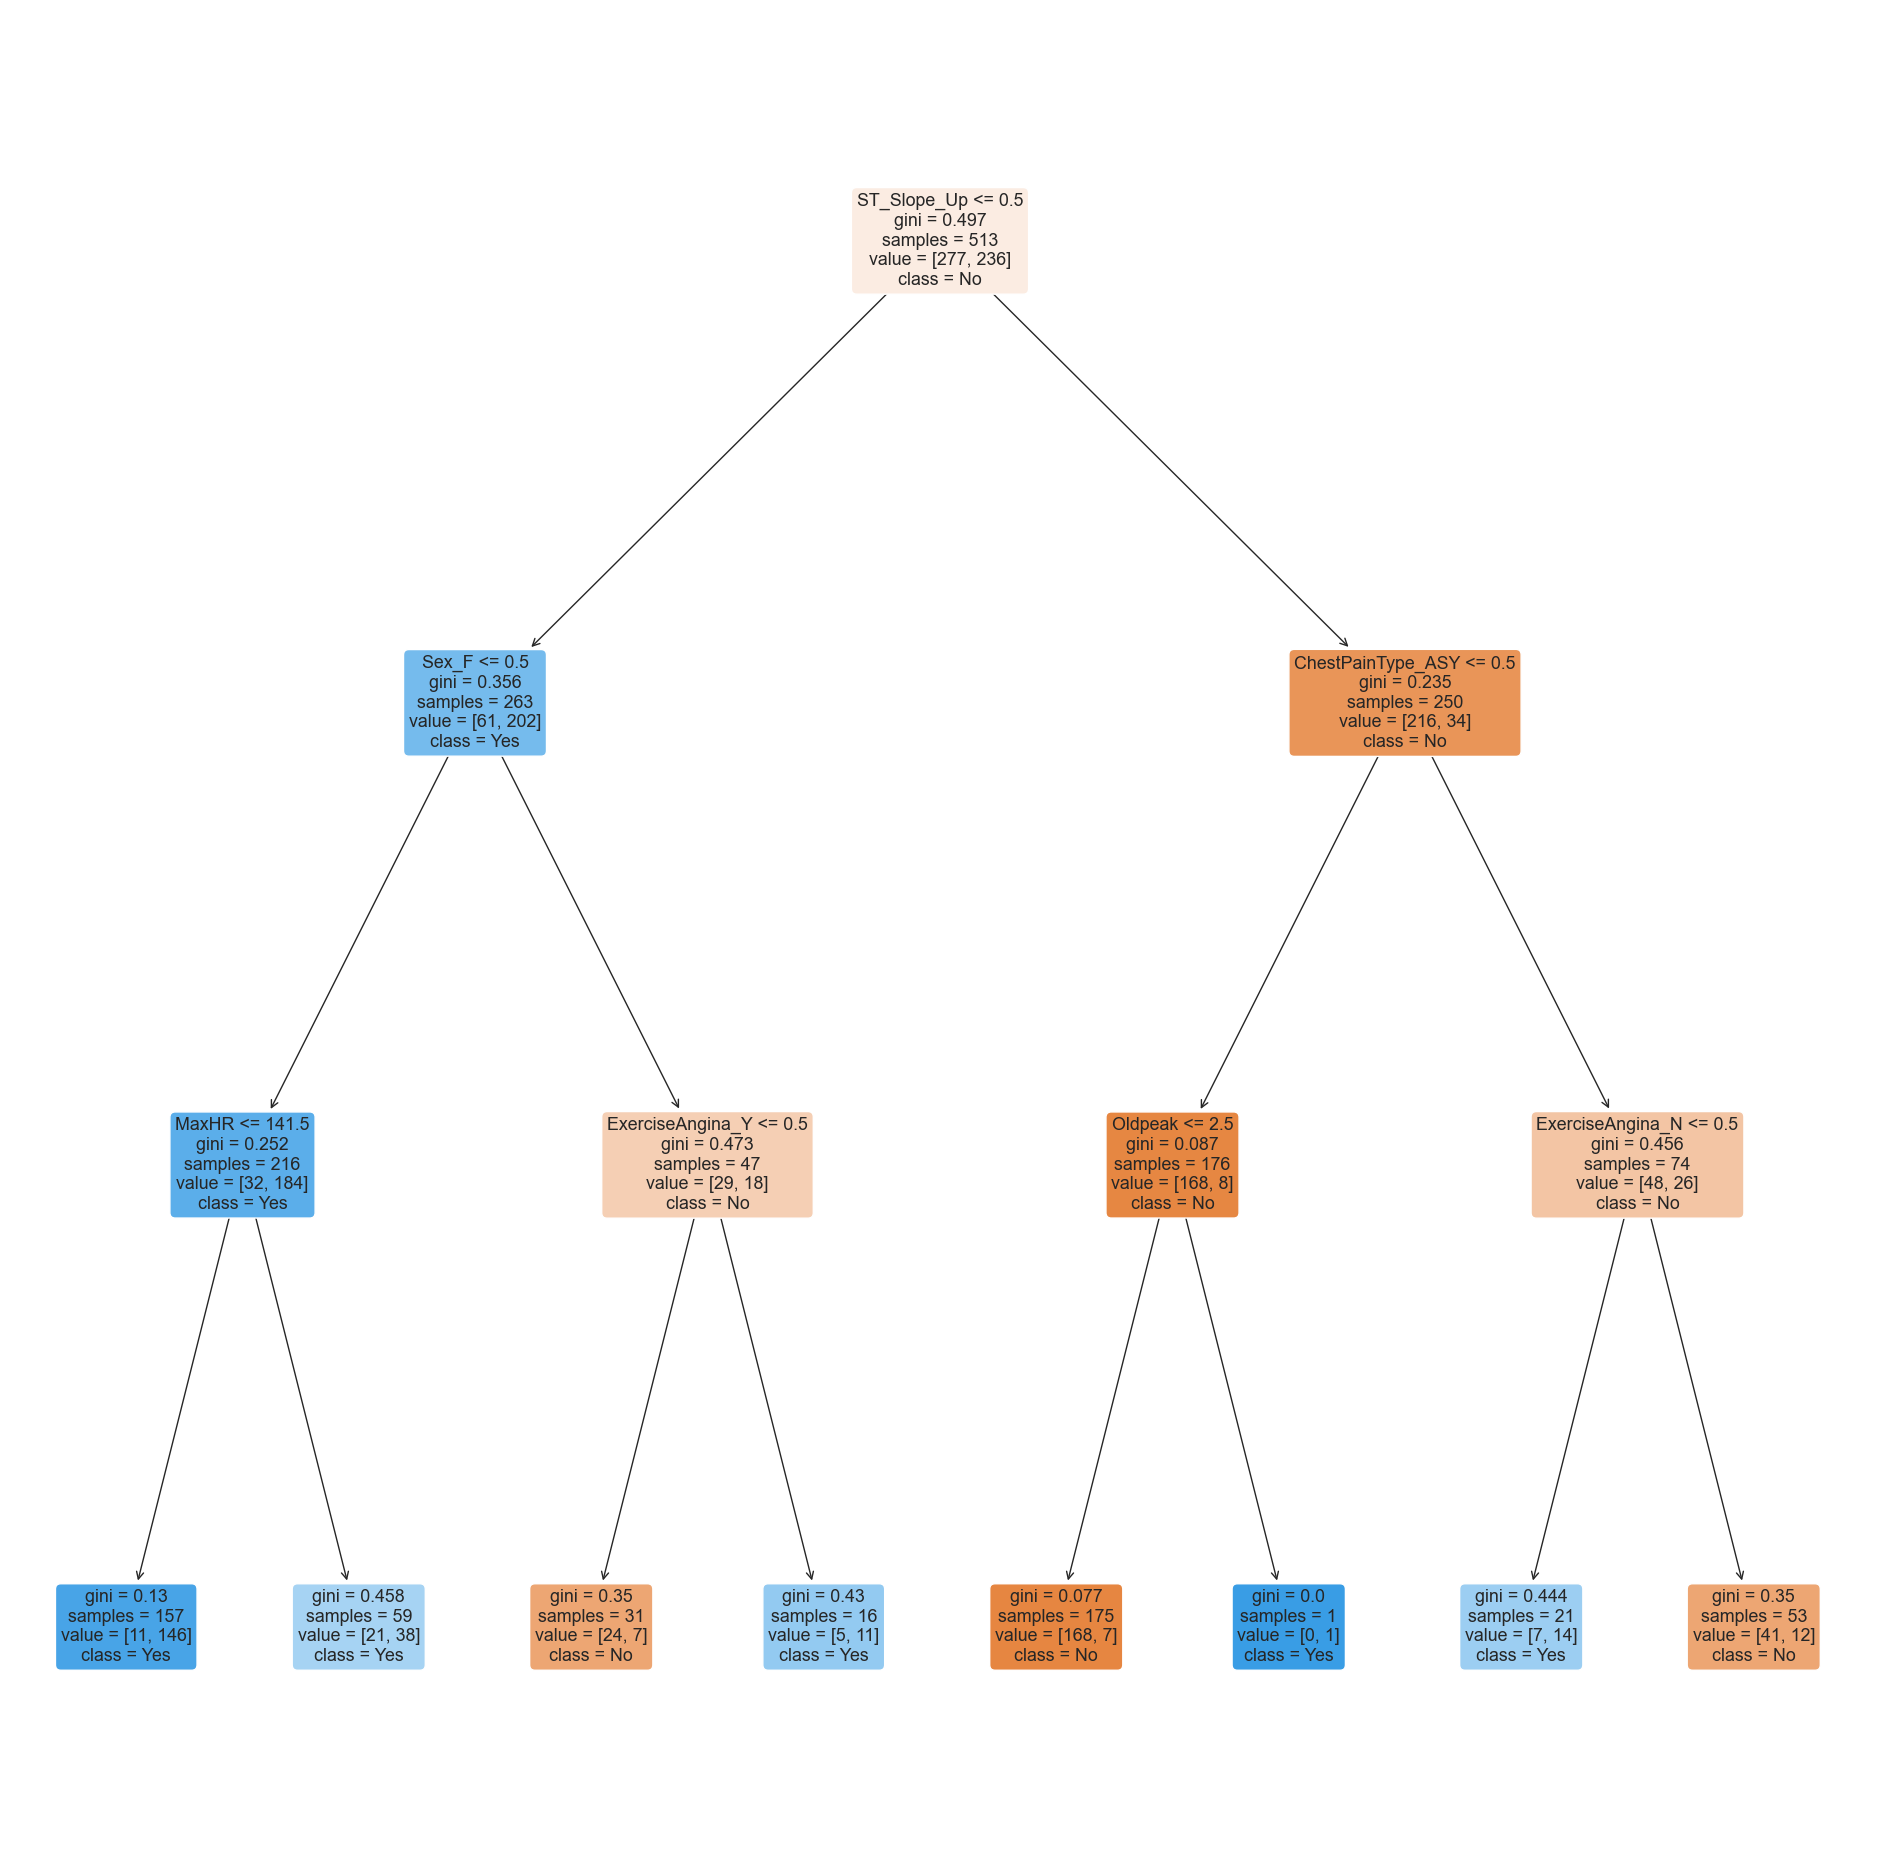

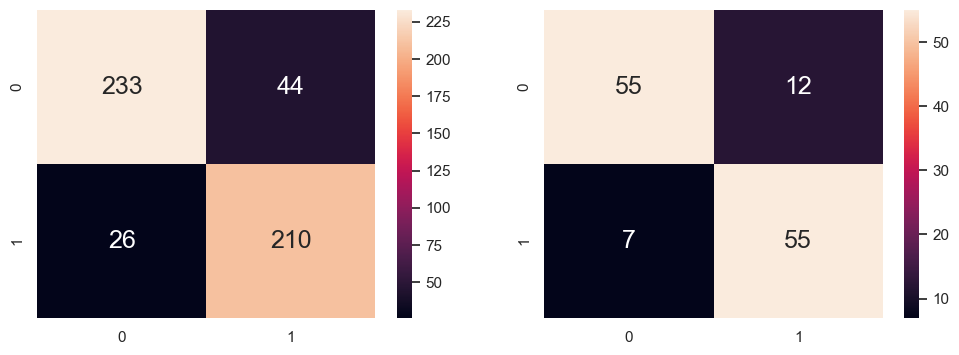

Train Data
              precision    recall  f1-score   support

           0       0.90      0.84      0.87       277
           1       0.83      0.89      0.86       236

    accuracy                           0.86       513
   macro avg       0.86      0.87      0.86       513
weighted avg       0.87      0.86      0.86       513


---------------------------------------------
Test Data
              precision    recall  f1-score   support

           0       0.89      0.82      0.85        67
           1       0.82      0.89      0.85        62

    accuracy                           0.85       129
   macro avg       0.85      0.85      0.85       129
weighted avg       0.86      0.85      0.85       129




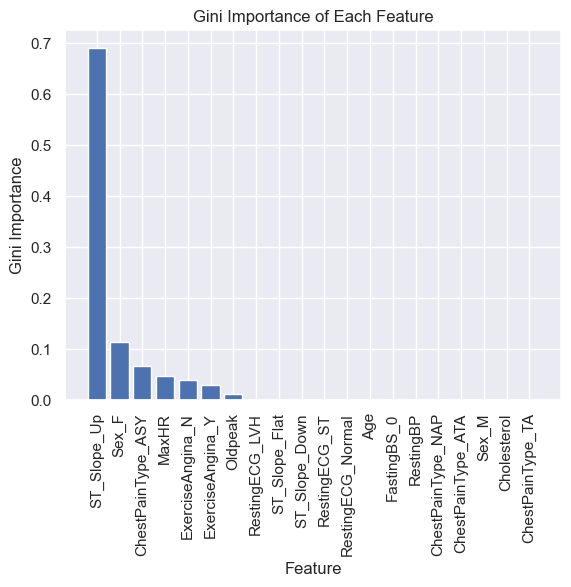

In [24]:
process(IPmedian_N0_outliers_heart_df)

## Classification Report Across All Models

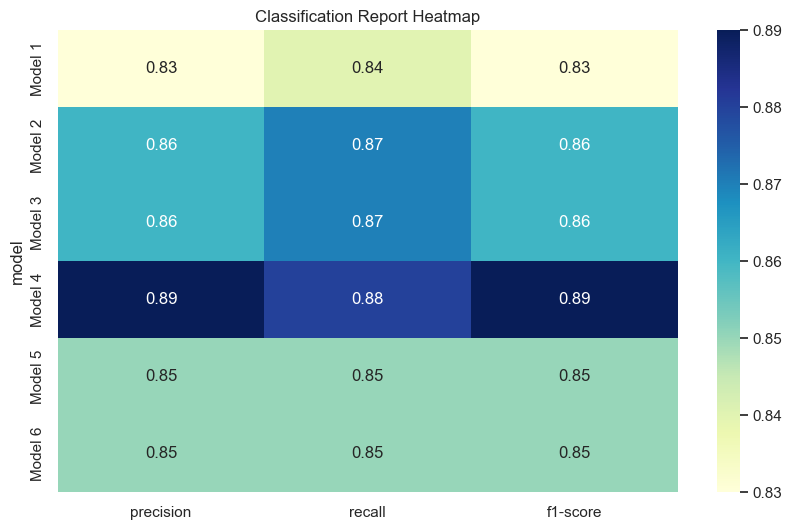

In [25]:
# create a list of all the classification reports using the macro avg

reports = [
    {'model': 'Model 1', 'precision': 0.83, 'recall': 0.84, 'f1-score': 0.83},
    {'model': 'Model 2', 'precision': 0.86, 'recall': 0.87, 'f1-score': 0.86},
    {'model': 'Model 3', 'precision': 0.86, 'recall': 0.87, 'f1-score': 0.86},
    {'model': 'Model 4', 'precision': 0.89, 'recall': 0.88, 'f1-score': 0.89},
    {'model': 'Model 5', 'precision': 0.85, 'recall': 0.85, 'f1-score': 0.85},
    {'model': 'Model 6', 'precision': 0.85, 'recall': 0.85, 'f1-score': 0.85}
]

# create a dataframe from the classification reports
df = pd.DataFrame(reports)

# set the model column as the index
df.set_index('model', inplace=True)

# create a heatmap using seaborn
plt.figure(figsize=(10,6))
sb.heatmap(df, cmap='YlGnBu', annot=True, fmt=".2f")
plt.title('Classification Report Heatmap')
plt.show()

MODEL 1 : Zero Imputation 

MODEL 2 : Mean Imputation 

MODEL 3 : Median Imputation 

MODEL 4 : Zero Imputation without Outliers

MODEL 5 : Mean Imputation without Outliers

MODEL 6 : Median Imputation without Outliers

### Evaluation 

From the scores, we can see that Models 2 and 3 (mean and median imputation, respectively) have similar and slightly higher scores than Model 1 (zero imputation), which suggests that imputing missing values with the mean or median of the available data can improve the model's performance.

Furthermore, Model 4 (zero imputation without outliers) has the **highest scores among all the models**, which indicates that **removing outliers can have a significant impact** on the model's accuracy and generalization. This is because outliers can distort the data distribution and bias the decision tree splits, leading to overfitting and poor performance on new data.

On the other hand, Models 5 and 6 (mean and median imputation without outliers, respectively) have lower scores than Model 4, which suggests that **removing outliers can be more effective than imputing missing values in improving the model's accuracy**

Regardless, **model 4 is the best model across all imputation and within imputation.**


## Feature pruning the multivariate decision tree

### Running IPzero_N0_outliers_heart_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588 entries, 0 to 587
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Sex_F              588 non-null    float64
 1   Sex_M              588 non-null    float64
 2   ChestPainType_ASY  588 non-null    float64
 3   ChestPainType_ATA  588 non-null    float64
 4   ChestPainType_NAP  588 non-null    float64
 5   ChestPainType_TA   588 non-null    float64
 6   FastingBS_0        588 non-null    float64
 7   RestingECG_LVH     588 non-null    float64
 8   RestingECG_Normal  588 non-null    float64
 9   RestingECG_ST      588 non-null    float64
 10  ExerciseAngina_N   588 non-null    float64
 11  ExerciseAngina_Y   588 non-null    float64
 12  ST_Slope_Down      588 non-null    float64
 13  ST_Slope_Flat      588 non-null    float64
 14  ST_Slope_Up        588 non-null    float64
dtypes: float64(15)
memory usage: 69.0 KB

<class 'pandas.core.frame.DataFrame'

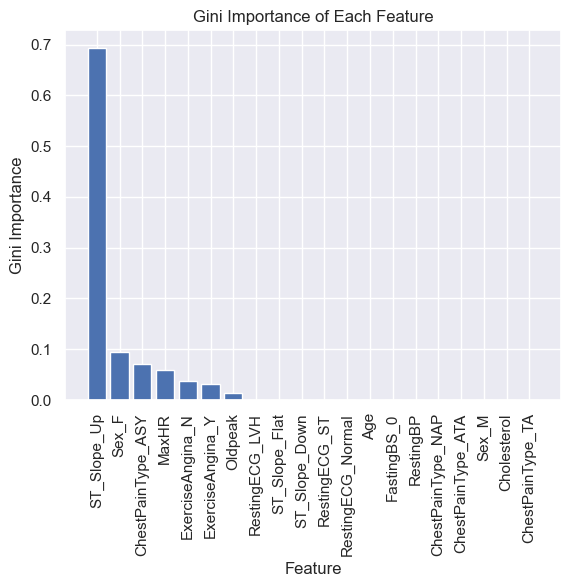

In [26]:
# Deleting Outliers and creating new Dataframe IPmean_N0_outliers_heart_df
IPzero_N0_outliers_heart_df = IPzero_heart_df.copy()
IPzero_N0_outliers_heart_df = remove_outliers(IPzero_N0_outliers_heart_df).reset_index(drop=True)

# Import the encoder from sklearn
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()

# OneHotEncoding of categorical predictors (not the response)
IPzero_N0_outliers_heart_df_cat = IPzero_N0_outliers_heart_df[['Sex','ChestPainType','FastingBS','RestingECG','ExerciseAngina','ST_Slope']]
ohe.fit(IPzero_N0_outliers_heart_df_cat)
IPzero_N0_outliers_heart_df_cat_ohe = pd.DataFrame(ohe.transform(IPzero_N0_outliers_heart_df_cat).toarray(), 
                                  columns=ohe.get_feature_names_out(IPzero_N0_outliers_heart_df_cat.columns))

# Check the encoded variables
IPzero_N0_outliers_heart_df_cat_ohe.info()

print('')

# Combining Numeric features with the OHE Categorical features
IPzero_N0_outliers_heart_df_num = IPzero_N0_outliers_heart_df[['Age','RestingBP','Cholesterol','MaxHR','Oldpeak']]
IPzero_N0_outliers_heart_df_res = IPzero_N0_outliers_heart_df['HeartDisease']
IPzero_N0_outliers_heart_df_ohe = pd.concat([IPzero_N0_outliers_heart_df_num,IPzero_N0_outliers_heart_df_cat_ohe, IPzero_N0_outliers_heart_df_res], 
                           sort = False, axis = 1).reindex(index=IPzero_N0_outliers_heart_df_num.index)

# Check the final dataframe
IPzero_N0_outliers_heart_df_ohe.info()

# Extract Response and Predictors
y = pd.DataFrame(IPzero_N0_outliers_heart_df_ohe['HeartDisease'])
X = pd.DataFrame(IPzero_N0_outliers_heart_df_ohe.drop('HeartDisease', axis = 1))

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2 , random_state = CONSTANT_SEED)

# Import GridSearch for hyperparameter tuning using Cross-Validation (CV)
from sklearn.model_selection import GridSearchCV

# Define the Hyper-parameter Grid to search on, in case of Multi-Variate Classification Tree
param_grid = {'max_depth': np.arange(2, 11)}             # depth of trees 2, 3, 4, 5, ..., 10

# Create the Hyper-parameter Grid
hpGrid = GridSearchCV(DecisionTreeClassifier(random_state = CONSTANT_SEED),   # the model family
                      param_grid,                 # the search grid
                      cv = 5,                     # 5-fold cross-validation
                      scoring = 'f1')       # score to evaluate

# Train the models using Cross-Validation
hpGrid.fit(X_train, y_train.HeartDisease.ravel())

# Decision Tree using Train Data
best_dectree = hpGrid.best_estimator_
best_dectree.fit(X_train, y_train)

# Get the Gini importance of all features
importances = best_dectree.feature_importances_

# Create a dataframe to store the Gini importance of each feature
gini_df = pd.DataFrame({'feature': X_test.columns, 'gini_importance': importances})

# Sort the features by their Gini importance in descending order
gini_df = gini_df.sort_values('gini_importance', ascending=False)

# Create a bar plot of the Gini importance of each feature
plt.bar(gini_df['feature'], gini_df['gini_importance'])
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Gini Importance')
plt.title('Gini Importance of Each Feature')
plt.show()

### Feature pruning Process

In [27]:
from sklearn import metrics

# Get the F1 score of the decision tree with all the features
y_test_pred = hpGrid.best_estimator_.predict(X_test)
f1_score_all = metrics.f1_score(y_test, y_test_pred ,average='macro' )

print("Initial Test Data")
print(classification_report(y_test,y_test_pred))
print(f"F1 score with all features: {f1_score_all:.4f}")
print()

# Create a list to store the F1 scores during pruning
f1_scores = [f1_score_all]

# Remove all features with a Gini importance of 0
gini_df = gini_df[gini_df['gini_importance'] > 0]

# Get the F1 score after removing all features with a Gini importance of 0
best_dectree.fit(X_train[gini_df['feature']], y_train)
y_test_pred = best_dectree.predict(X_test[gini_df['feature']])
f1_score = metrics.f1_score(y_test, y_test_pred, average='macro')
print("After removing all features with Gini importance of 0")
print(metrics.classification_report(y_test, y_test_pred))
print(f"F1 score after removing all 0 Gini importance features: {f1_score:.4f}")
print()

# Prune the features one by one until there are only 3 features left
while len(gini_df) > 3:
    # Fit the decision tree with the remaining features
    best_dectree.fit(X_train[gini_df['feature']], y_train)

    # Get the F1 score on the test set
    y_test_pred = best_dectree.predict(X_test[gini_df['feature']])
    f1_score = metrics.f1_score(y_test, y_test_pred, average='macro')

    # Remove the feature with the lowest Gini importance
    removed_feature = gini_df.iloc[-1]['feature']
    gini_df = gini_df.drop(gini_df.index[-1])
    print(f'Removing feature: {removed_feature}')
    print('')

    # Get the classification report
    report = metrics.classification_report(y_test, y_test_pred)
    print(f'Classification report after removing feature:\n {report}')
    print(f"F1 score after removing feature: {f1_score:.4f}")
    print()

    # Add the F1 score to a list
    f1_scores.append(f1_score)


Initial Test Data
              precision    recall  f1-score   support

           0       0.88      0.94      0.91        67
           1       0.91      0.82      0.87        51

    accuracy                           0.89       118
   macro avg       0.89      0.88      0.89       118
weighted avg       0.89      0.89      0.89       118

F1 score with all features: 0.8862

After removing all features with Gini importance of 0
              precision    recall  f1-score   support

           0       0.88      0.94      0.91        67
           1       0.91      0.82      0.87        51

    accuracy                           0.89       118
   macro avg       0.89      0.88      0.89       118
weighted avg       0.89      0.89      0.89       118

F1 score after removing all 0 Gini importance features: 0.8862

Removing feature: Oldpeak

Classification report after removing feature:
               precision    recall  f1-score   support

           0       0.88      0.94      0.91  

### Printing the F1 score in a line plot 

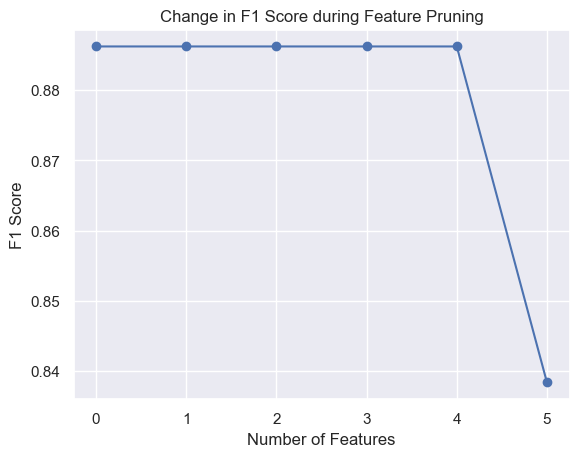

In [28]:
# Create a list of the x-axis values (number of remaining features)
x_values = list(range(len(f1_scores) + 1))

# Add the F1 score with all the features to the list
f1_scores = [f1_score_all] + f1_scores

# Create the line plot
plt.plot(x_values, f1_scores, marker='o')
plt.xticks(x_values)
plt.xlabel('Number of Features')
plt.ylabel('F1 Score')
plt.title('Change in F1 Score during Feature Pruning')
plt.show()

## Evaluation 

It is clear that after the removal of the 4th most important feature(based of gini) **'MaxHR'** , there is a steep degradation in the F1 score in the model . What this might suggest that the following features of greater importance namely **'ChestPainType_ASY'** , **'Sex_F'** and **'ST_Slope_Up'** are important features that might prove useful in determining if a patient have **'HeartDisease'**.

## Best Feature conclusion 

**'MaxHR'** , **'ChestPainType_ASY'** , **'Sex_F'** and **'ST_Slope_Up'** are the most important variables that might indicate a patient has **'HeartDisease'**

## Best model with the Best Features

In [29]:
IPzero_N0_outliers_heart_df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
583,57,F,ASY,140,241,0,Normal,123,Y,0.2,Flat,1
584,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
585,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
586,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


In [30]:
def Best_Model_process(name_df):
    # One hot implementation
    ohe = OneHotEncoder()

    # Select the categorical columns to encode
    cat_cols = ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

    # Fit the encoder on the selected categorical columns
    ohe.fit(name_df[cat_cols])

    # One-hot encode the selected categorical columns
    name_df_cat_ohe = pd.DataFrame(ohe.transform(name_df[cat_cols]).toarray(),
                                   columns=ohe.get_feature_names_out(cat_cols))

    # Select the numeric columns to keep
    num_cols = ['MaxHR']

    # Select the binary columns to keep
    bin_cols = ['ChestPainType_ASY', 'Sex_F', 'ST_Slope_Up']

    # Combine the selected columns into a final DataFrame
    name_df_selected = pd.concat([name_df[num_cols], name_df_cat_ohe[bin_cols], name_df['HeartDisease']],
                                 sort = False, axis = 1).reindex(index=name_df[num_cols].index)

    # Check the final dataframe
    name_df_selected.info()
    
    print('')


    # Extract Response and Predictors
    y = pd.DataFrame(name_df_selected['HeartDisease'])
    X = pd.DataFrame(name_df_selected.drop('HeartDisease', axis = 1))
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = CONSTANT_SEED)
    
    # Import GridSearch for hyperparameter tuning using Cross-Validation (CV)
    from sklearn.model_selection import GridSearchCV

    # Define the Hyper-parameter Grid to search on, in case of Multi-Variate Classification Tree
    param_grid = {'max_depth': np.arange(2, 11)}             # depth of trees 2, 3, 4, 5, ..., 11

    # Create the Hyper-parameter Grid
    hpGrid = GridSearchCV(DecisionTreeClassifier(random_state = CONSTANT_SEED),   # the model family
                      param_grid,                 # the search grid
                      cv=5,                       # 5-fold cross-validation
                      scoring='f1',               # score to evaluate
                      )     

    # Train the models using Cross-Validation
    hpGrid.fit(X_train, y_train.HeartDisease.ravel())
    
    # Fetch the best Model or the best set of Hyper-parameters
    print(hpGrid.best_estimator_)
    
    print('')
    
    # Print the score (accuracy) of the best Model after CV
    print(np.abs(hpGrid.best_score_))

    # get the best parameter
    best_para = hpGrid.best_estimator_
    
    # Decision Tree using Train Data
    best_dectree = hpGrid.best_estimator_
    best_dectree.fit(X_train, y_train)

    # Plot the trained Decision Tree
    f = plt.figure(figsize=(24,24))
    plot_tree(best_dectree, filled=True, rounded=True, 
          feature_names=X_train.columns, 
          class_names=["No","Yes"])

    plt.show()

    # Predict the Response corresponding to Predictors
    y_train_pred = best_dectree.predict(X_train)

    # Predict the Response corresponding to Predictors
    y_test_pred = best_dectree.predict(X_test)

    # Plot the Confusion Matrix for Train and Test
    f, axes = plt.subplots(1, 2, figsize=(12, 4))
    sb.heatmap(confusion_matrix(y_train, y_train_pred),
           annot=True, fmt=".0f", annot_kws={"size": 18}, ax=axes[0])
    sb.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot=True, fmt=".0f", annot_kws={"size": 18}, ax=axes[1])
    plt.show()
    
    #Predict the Response corresponding to Predictors
    y_train_pred = hpGrid.best_estimator_.predict(X_train)

    #Print the Classification Accuracy
    print("Train Data")
    print(classification_report(y_train,y_train_pred))
    print()

    print('---------------------------------------------')

    #Predict the Response corresponding to Predictors
    y_test_pred = hpGrid.best_estimator_.predict(X_test)

    #Print the Classification Accuracy
    print("Test Data")
    print(classification_report(y_test,y_test_pred))
    print()
    
    return
    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588 entries, 0 to 587
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   MaxHR              588 non-null    int64  
 1   ChestPainType_ASY  588 non-null    float64
 2   Sex_F              588 non-null    float64
 3   ST_Slope_Up        588 non-null    float64
 4   HeartDisease       588 non-null    int64  
dtypes: float64(3), int64(2)
memory usage: 23.1 KB

DecisionTreeClassifier(max_depth=6, random_state=100)

0.7865751384653047


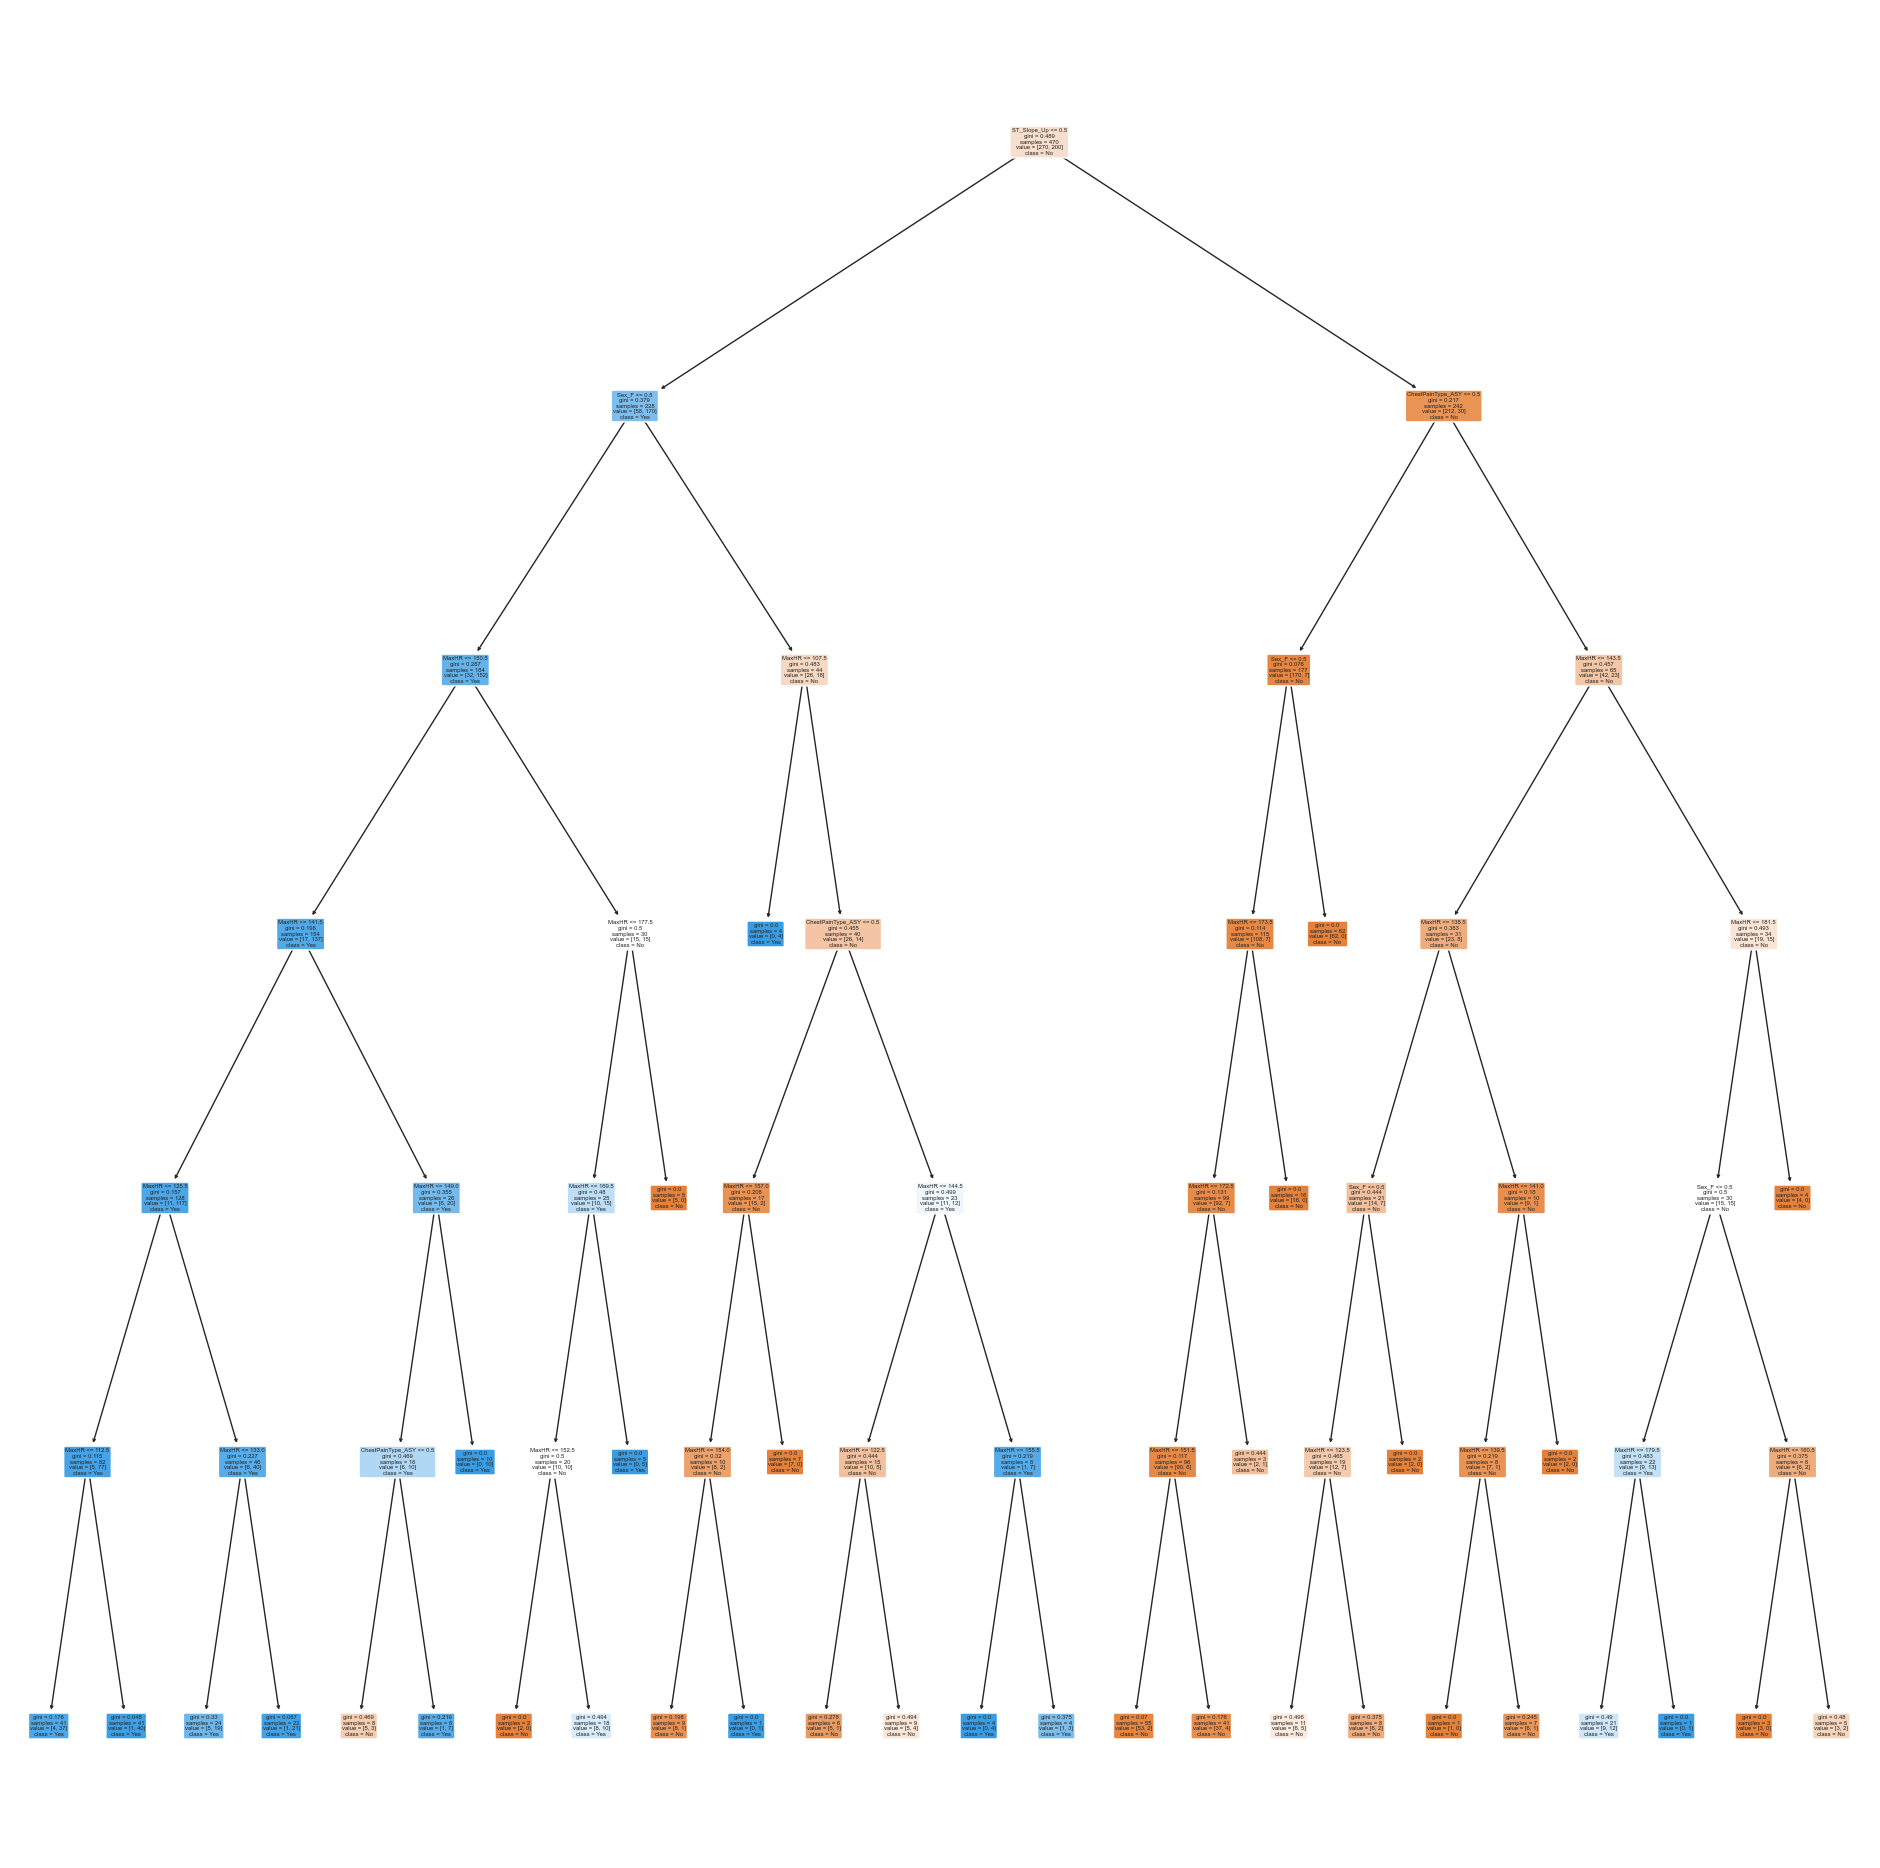

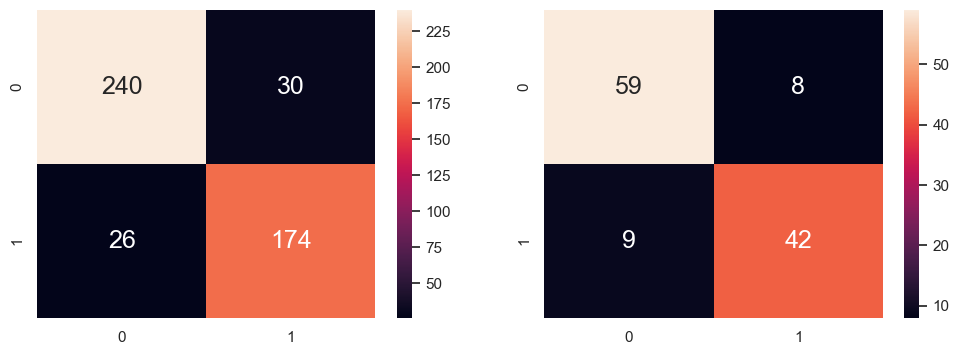

Train Data
              precision    recall  f1-score   support

           0       0.90      0.89      0.90       270
           1       0.85      0.87      0.86       200

    accuracy                           0.88       470
   macro avg       0.88      0.88      0.88       470
weighted avg       0.88      0.88      0.88       470


---------------------------------------------
Test Data
              precision    recall  f1-score   support

           0       0.87      0.88      0.87        67
           1       0.84      0.82      0.83        51

    accuracy                           0.86       118
   macro avg       0.85      0.85      0.85       118
weighted avg       0.86      0.86      0.86       118




In [31]:
Best_Model_process(IPzero_N0_outliers_heart_df)

## Evaluation of model before and after feature pruning 

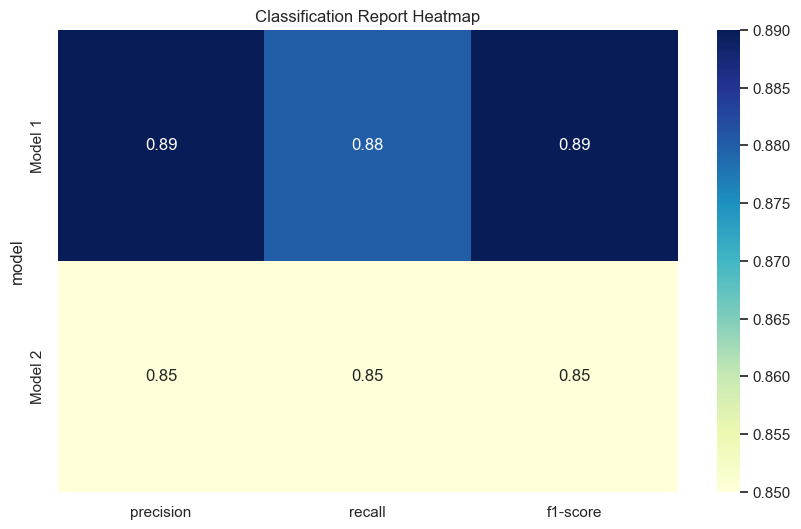

In [32]:
# create a list of all the classification reports

reports = [
    {'model': 'Model 1', 'precision': 0.89, 'recall': 0.88, 'f1-score': 0.89},
    {'model': 'Model 2', 'precision': 0.85, 'recall': 0.85, 'f1-score': 0.85},
    
]

# create a dataframe from the classification reports
df = pd.DataFrame(reports)

# set the model column as the index
df.set_index('model', inplace=True)

# create a heatmap using seaborn
plt.figure(figsize=(10,6))
sb.heatmap(df, cmap='YlGnBu', annot=True, fmt=".2f")
plt.title('Classification Report Heatmap')
plt.show()

MODEL 1: IPzero_N0_outliers_heart_df Before feature pruning 

MODEL 2: IPzero_N0_outliers_heart_df After feature pruning 

Even After a max depth of 6, the multivariate decision tree result in a poor result , as seen by the decrease in 0.4 F1 score.

However, **'MaxHR'** , **'ChestPainType_ASY'** , **'Sex_F'** and **'ST_Slope_Up'** may still be important features that we can explore in the proceeding machine learning models